# ROME GEOSPATIAL ANALYSIS
## Barbara Innamorato 213907
### Geospatial Analysis and Representation for Data Science - University of Trento


Dataset used for this project are:

1.   rome_listings.csv and neighborhoods.geojson taken by *Inside Airbnb* http://insideairbnb.com/get-the-data.html
2.   rioni.shp : containing 22 "rioni" in the old town of Rome http://websit.cittametropolitanaroma.it/Download.aspx
3.   quartieri.shp : containing the others 35 neighborhoods of Rome that surround the historic center outside the Aurelian Walls, including the three "marine districts" into which Ostia is divided. http://websit.cittametropolitanaroma.it/Download.aspx

We need these two shapefiles since, as we will see, districts in the listing file and in the geojson file are not properly neihgborhoods, instead they are 15 municipalities.

There is no data on the 53 areas straddling the GRA and up to the municipal boundaries that, along with other 6 passed to the municipality of Fiumicino in 1992, subdivide the Agro Romano. For this reason the plot of rome that I will present is divided into two parts.

To run the project I suggest to put all the files on Google Drive (ROMA_RIONI, ROMA_QUARTIERI, rome_listings_csv, neighborhoods.geojson, pbf) in a folder called Colab Notebook and then mount the drive running cells below.


# Install packages

In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

In [2]:
!pip install contextily

In [3]:
!pip install geopandas

In [4]:
!pip install git+https://github.com/HTenkanen/pyrosm.git@master

  Cloning https://github.com/HTenkanen/pyrosm.git (to revision master) to /tmp/pip-req-build-rvp2tx83
  Running command git clone -q https://github.com/HTenkanen/pyrosm.git /tmp/pip-req-build-rvp2tx83
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyrosm: filename=pyrosm-0.6.0-cp37-cp37m-linux_x86_64.whl size=5307160 sha256=77be43a2ffffd7a0ee8117120d72a0893f75b421221d56cc53b88bf4422d995e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9agztul/wheels/d3/82/3f/ba4d3b63aed3b4dc3f56309beb2570deb0c6b87020fa5c1114
Successfully built pyrosm


In [5]:
!pip install osmnx==0.16.2

  Using cached https://files.pythonhosted.org/packages/ce/63/74c0b6184b6b169b121bb72458818ee60a7d7c436d7b1907bd5874188c55/matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [6]:
!pip install matplotlib==3.2.2

  Using cached https://files.pythonhosted.org/packages/d9/aa/22af3c636d6b87e8d7f8f28c02da338e348ed08beff1e2b58843f0f62fc1/matplotlib-3.2.2-cp37-cp37m-manylinux1_x86_64.whl
ERROR: osmnx 0.16.2 has requirement matplotlib>=3.3, but you'll have matplotlib 3.2.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.4.1
    Uninstalling matplotlib-3.4.1:
      Successfully uninstalled matplotlib-3.4.1


In [7]:
!pip install mapclassify

In [8]:
!pip install owslib

In [9]:
!pip install pyshp

In [10]:
!pip install bmi-arcgis-restapi

In [11]:
from pprint import pprint
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
import contextily as ctx

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Loading data and brief exploratory analysis

In [12]:
#You can mount to google drive by running following cells
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#!ls "/content/drive/My Drive"
#!ls "/content/drive/My Drive/Colab Notebooks/" 
!cd "/content/drive/My Drive/Colab Notebooks" 

**rome listings csv then trasformed in a geodataframe --> rome_listings_geo**

In [14]:
#read listings csv as pandas dataframe
rome = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rome_listings.csv')
print(rome.shape)
rome.head()

(27647, 16)


id  ... availability_365
0   2737  ...              365
1   2903  ...              365
2   3079  ...                1
3  11834  ...              364
4  12398  ...              362

[5 rows x 16 columns]

In [15]:
#exploring rome 
rome.columns
cols = ['name',
        'host_name',
        'neighbourhood',
        'latitude',
        'longitude',
        'room_type',
        'price',
        'minimum_nights']

rome = rome[cols]
rome.head()

name host_name  ... price  minimum_nights
0           Elif's room in cozy, clean flat.      Elif  ...    21               7
1          Stay a night in Calisto6 B&B Rome    Andrea  ...    37               1
2  Cozy apartment  (2-4)with Colisseum  view     Laura  ...   105               3
3            Roma "Charming Boschetto House"    Serena  ...    90               2
4        Casa Donatello - Home far from Home       Gea  ...    73               1

[5 rows x 8 columns]

In [16]:
#get info
rome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27647 entries, 0 to 27646
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            27640 non-null  object 
 1   host_name       27636 non-null  object 
 2   neighbourhood   27647 non-null  object 
 3   latitude        27647 non-null  float64
 4   longitude       27647 non-null  float64
 5   room_type       27647 non-null  object 
 6   price           27647 non-null  int64  
 7   minimum_nights  27647 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.7+ MB


In [17]:
#check for missing values in each col
rome.isnull().sum().to_frame()

0
name             7
host_name       11
neighbourhood    0
latitude         0
longitude        0
room_type        0
price            0
minimum_nights   0


*   There are no missing values in latitude and longitude so that it is possible to create the geodataframe with rome listings. 
*   It is applied the specific EPSG for Rome, that is the MONTE MARIO 4265


In [18]:
#create the geodataframe for rome
rome_listings_geo = gpd.GeoDataFrame(
    rome,
    crs = 'EPSG:4265', #specify the system of coordinates 
    geometry=gpd.points_from_xy(rome.longitude,rome.latitude))   #and instruct geopandas regarding in which columns it can find the spatial coordinates of the units

rome_listings_geo.head()


name  ...                   geometry
0           Elif's room in cozy, clean flat.  ...  POINT (12.48355 41.87218)
1          Stay a night in Calisto6 B&B Rome  ...  POINT (12.47002 41.88826)
2  Cozy apartment  (2-4)with Colisseum  view  ...  POINT (12.49163 41.89503)
3            Roma "Charming Boschetto House"  ...  POINT (12.49058 41.89574)
4        Casa Donatello - Home far from Home  ...  POINT (12.46809 41.92584)

[5 rows x 9 columns]

In [19]:
rome_listings_geo.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [20]:
s = set(rome_listings_geo.neighbourhood)
print(len(s))
pprint(s)


15
{'I Centro Storico',
 'II Parioli/Nomentano',
 'III Monte Sacro',
 'IV Tiburtina',
 'IX Eur',
 'V Prenestino/Centocelle',
 'VI Roma delle Torri',
 'VII San Giovanni/Cinecittà',
 'VIII Appia Antica',
 'X Ostia/Acilia',
 'XI Arvalia/Portuense',
 'XII Monte Verde',
 'XIII Aurelia',
 'XIV Monte Mario',
 'XV Cassia/Flaminia'}


These are not properly neighborhoods, but they are the 15 municipalities (municipi)

In [21]:
# create a dictionary with number of municipio and name
coords = {}
for el in s:
    k = el.split()[0]
    v = el[len(k)+1:]
    coords[k] = v

pprint(coords)

{'I': 'Centro Storico',
 'II': 'Parioli/Nomentano',
 'III': 'Monte Sacro',
 'IV': 'Tiburtina',
 'IX': 'Eur',
 'V': 'Prenestino/Centocelle',
 'VI': 'Roma delle Torri',
 'VII': 'San Giovanni/Cinecittà',
 'VIII': 'Appia Antica',
 'X': 'Ostia/Acilia',
 'XI': 'Arvalia/Portuense',
 'XII': 'Monte Verde',
 'XIII': 'Aurelia',
 'XIV': 'Monte Mario',
 'XV': 'Cassia/Flaminia'}


In [22]:
from shapely.geometry import Point

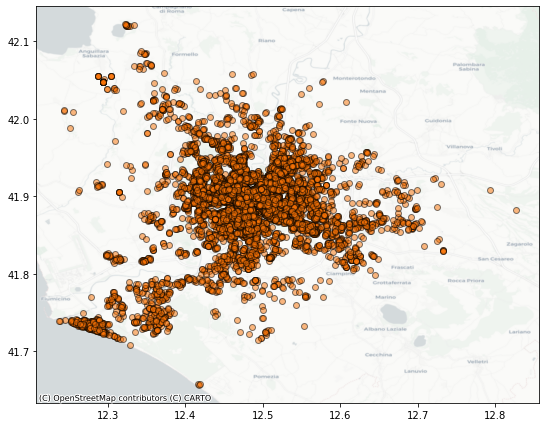

In [23]:
ax = rome_listings_geo.to_crs(epsg=4265).plot(color='xkcd:orange',
                            figsize=(9,9),alpha=0.5,
                            edgecolor='black')
ctx.add_basemap(ax,
      crs=rome_listings_geo.to_crs(epsg=4326).crs.to_string(),
      source=ctx.providers.CartoDB.Positron)

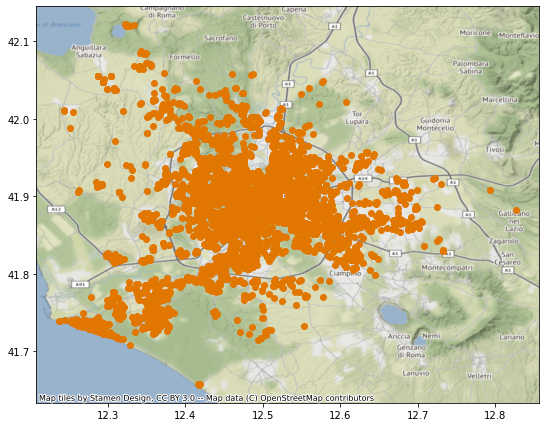

In [24]:
# and with a different basemap
ax = rome_listings_geo.plot(color="xkcd:pumpkin", figsize=(9, 9))
ctx.add_basemap(ax, crs=rome_listings_geo.crs.to_string())

In [25]:
# number of rooms available considering only 15 bigger neihgb
p= rome_listings_geo.groupby('neighbourhood').size().to_frame('num_bb').sort_values('num_bb', ascending=False).reset_index()
print(sum(p.num_bb)==rome_listings_geo.shape[0])
p

True


neighbourhood  num_bb
0             I Centro Storico   14874
1   VII San Giovanni/Cinecittà    2079
2         II Parioli/Nomentano    1991
3                 XIII Aurelia    1697
4              XII Monte Verde    1323
5      V Prenestino/Centocelle    1087
6            VIII Appia Antica     804
7               X Ostia/Acilia     631
8              XIV Monte Mario     573
9                 IV Tiburtina     532
10        XI Arvalia/Portuense     531
11          XV Cassia/Flaminia     501
12             III Monte Sacro     426
13                      IX Eur     347
14         VI Roma delle Torri     251

Grouping by neighborhoods we get that most rooms available are in CENTRO STORICO (MUNUCPIO I), CINECITTA' (MUNUCPIO VVI), PARIOLI (MUNUCPIO II). 

(for further comparison)

**Load the geojson file with neighborhoods**

In [26]:
# read geojson neighbouroods data
neighbourhoods = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/rome_neighbourhoods.geojson", driver="GeoJson")
print(neighbourhoods.shape)

#check missing values
neighbourhoods.isnull().sum().to_frame()

(15, 3)


0
neighbourhood         0
neighbourhood_group  15
geometry              0

In [27]:
# drop the column 'neighbourhood_group' since there are all None
cols = ['neighbourhood','geometry']
neighbourhoods = neighbourhoods[cols]
neighbourhoods.head()

neighbourhood                                           geometry
0            I Centro Storico  MULTIPOLYGON (((12.44396 41.93390, 12.44472 41...
1             III Monte Sacro  MULTIPOLYGON (((12.56321 42.07464, 12.56269 42...
2                IV Tiburtina  MULTIPOLYGON (((12.63542 41.95729, 12.63696 41...
3         VI Roma delle Torri  MULTIPOLYGON (((12.70671 41.93375, 12.70691 41...
4  VII San Giovanni/Cinecittà  MULTIPOLYGON (((12.51668 41.89194, 12.52266 41...

In [28]:
neighbourhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
neighbourhoods = neighbourhoods.to_crs(epsg=4265)

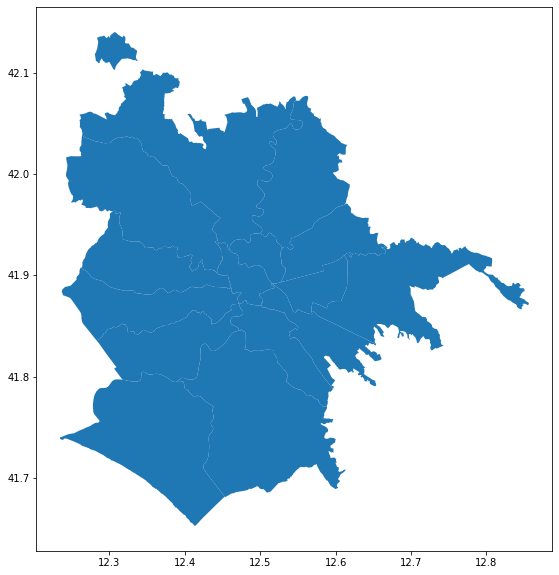

In [30]:
neighbourhoods.plot(figsize=(10,10))

It is possible to check that in the geojson file there are no additional information since also here there are the 15 municipalities

In [31]:
rome_lista = set(rome_listings_geo.neighbourhood)
print('from rome_listing_geo')
pprint(rome_lista)
print()
neigh_lista = set(neighbourhoods.neighbourhood)
print('from neighbourhoods')
pprint(neigh_lista)
print()
print('are information equal?',rome_lista == neigh_lista)
#since the two columns about neighb are equal, we can safely drop one of them

from rome_listing_geo
{'I Centro Storico',
 'II Parioli/Nomentano',
 'III Monte Sacro',
 'IV Tiburtina',
 'IX Eur',
 'V Prenestino/Centocelle',
 'VI Roma delle Torri',
 'VII San Giovanni/Cinecittà',
 'VIII Appia Antica',
 'X Ostia/Acilia',
 'XI Arvalia/Portuense',
 'XII Monte Verde',
 'XIII Aurelia',
 'XIV Monte Mario',
 'XV Cassia/Flaminia'}

from neighbourhoods
{'I Centro Storico',
 'II Parioli/Nomentano',
 'III Monte Sacro',
 'IV Tiburtina',
 'IX Eur',
 'V Prenestino/Centocelle',
 'VI Roma delle Torri',
 'VII San Giovanni/Cinecittà',
 'VIII Appia Antica',
 'X Ostia/Acilia',
 'XI Arvalia/Portuense',
 'XII Monte Verde',
 'XIII Aurelia',
 'XIV Monte Mario',
 'XV Cassia/Flaminia'}

are information equal? True


Since the two columns about neighborhoods are equal, we can safely drop one of them (that's the reason why I do not perform a spatial join). 

Neighborhoods in the rome_listing_geo dataset are effectively municipalities  and not neighbrhoods, infact these are now more than 57 grouped in 15 municipalities (MUNICIPI) that we have here. So what is called neighbourhood in the geojson and in the rome_listings_geo files, are effectively municiplaity. 

Rome neighborhoods are obtained combinig the ROMA_RIONI and ROMA_QUARTIERI shapefiles founded here:
http://websit.cittametropolitanaroma.it/Download.aspx with the listings

**Load ROMA_RIONI, ROMA_QUARTIERI**

In [32]:
#load 22 quartieri "centro storico"
rioni_gpd = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/ROMA_RIONI.shp', encoding='utf-8',epsg="EPSG:4265")
print(rioni_gpd.shape) # (35, 16)
print(rioni_gpd.crs) # no crs

(22, 16)
None


In [33]:
# load 35 quartieri
qu_gpd = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/ROMA_QUARTIERI.shp', encoding='utf-8',epsg="EPSG:4265")
print(qu_gpd.shape) # (35, 16)
print(qu_gpd.crs) # no crs


(35, 16)
None


In [34]:
#dropping columns
col_ri = ['NOME_RIONE', 'NUMERO_RIO', 'MUNICIPIO', 'SEDE_MUNIC', 'POP_RES_RI','SUPERFICIE','geometry']
rioni_gpd = rioni_gpd[col_ri]

col_qu = ['NOME_QUART', 'NUMERO_QUA', 'MUNICIPIO', 'SEDE_MUNIC', 'POP_RES_QU','SUPERFICIE','geometry']
qu_gpd = qu_gpd[col_qu]

In [35]:
#rename columns in both dataset
qu_gpd.rename(columns={'NOME_QUART':'neighbourhood','NUMERO_QUA':'NUMERO','POP_RES_QU':'POPOLAZIONE'},inplace=True)
rioni_gpd.rename(columns={'NOME_RIONE':'neighbourhood','NUMERO_RIO':'NUMERO','POP_RES_RI':'POPOLAZIONE'},inplace=True)


In [36]:
print(qu_gpd.shape)
qu_gpd.head()

(35, 7)


neighbourhood  ...                                           geometry
0   ALESSANDRINO  ...  POLYGON ((2320316.271 4639683.634, 2320311.019...
1  APPIO CLAUDIO  ...  POLYGON ((2318733.325 4635812.067, 2318677.589...
2   APPIO LATINO  ...  POLYGON ((2315309.614 4637246.162, 2315284.545...
3      DON BOSCO  ...  POLYGON ((2319797.361 4637985.375, 2319771.773...
4         EUROPA  ...  POLYGON ((2310836.009 4634651.786, 2310832.801...

[5 rows x 7 columns]

In [37]:
print(rioni_gpd.shape)
rioni_gpd.head()

(22, 7)


neighbourhood  ...                                           geometry
0       S. SABA  ...  POLYGON ((2310990.989 4639146.796, 2310968.773...
1   SALLUSTIANO  ...  POLYGON ((2312546.879 4642542.584, 2312297.843...
2     TESTACCIO  ...  POLYGON ((2310990.246 4639098.094, 2310973.935...
3    TRASTEVERE  ...  POLYGON ((2310911.726 4640454.872, 2310898.688...
4         TREVI  ...  POLYGON ((2311243.810 4641264.063, 2311210.833...

[5 rows x 7 columns]

Now that we have only columns of interest, we can merge the two dataset


In [38]:
quartieri_totali = qu_gpd.append([rioni_gpd]).reset_index().drop(columns='index')
print(quartieri_totali.shape)
quartieri_totali

(57, 7)


neighbourhood  ...                                           geometry
0            ALESSANDRINO  ...  POLYGON ((2320316.271 4639683.634, 2320311.019...
1           APPIO CLAUDIO  ...  POLYGON ((2318733.325 4635812.067, 2318677.589...
2            APPIO LATINO  ...  POLYGON ((2315309.614 4637246.162, 2315284.545...
3               DON BOSCO  ...  POLYGON ((2319797.361 4637985.375, 2319771.773...
4                  EUROPA  ...  POLYGON ((2310836.009 4634651.786, 2310832.801...
5                FLAMINIO  ...  POLYGON ((2310332.403 4642954.484, 2310311.722...
6            GIANICOLENSE  ...  POLYGON ((2310409.332 4639969.005, 2310290.381...
7             MONTE SACRO  ...  POLYGON ((2316337.985 4644819.265, 2316332.765...
8        MONTE SACRO ALTO  ...  POLYGON ((2318236.844 4646709.781, 2318187.985...
9        GIULIANO DALMATA  ...  POLYGON ((2313909.074 4633535.677, 2313911.333...
10  LIDO DI CASTEL FUSANO  ...  POLYGON ((2299842.134 4620637.227, 2299807.929...
11  LIDO DI OSTIA LEVANTE  ...  POLYGON ((2296250.101 4623370.169, 2296195.296...
12  LIDO DI OSTIA PONENTE  ...  POLYGON ((2293740.806 4626002.018, 2293785.566...
13       APPIO PIGNATELLI  ...  POLYGON ((2316711.465 4634482.585, 2316676.501...
14              ARDEATINO  ...  POLYGON ((2315780.020 4634323.322, 2315754.754...
15                AURELIO  ...  POLYGON ((2309378.653 4640507.673, 2309296.223...
16              COLLATINO  ...  POLYGON ((2316076.051 4640792.464, 2316074.847...
17         DELLA VITTORIA  ...  POLYGON ((2310267.423 4643866.478, 2310238.949...
18                PARIOLI  ...  POLYGON ((2313507.565 4645396.926, 2313503.170...
19              PIANCIANO  ...  POLYGON ((2312562.935 4643875.446, 2312513.177...
20             PIETRALATA  ...  POLYGON ((2318611.042 4644275.258, 2318603.925...
21          PONTE MAMMOLO  ...  POLYGON ((2319929.738 4644650.763, 2319901.412...
22              PORTUENSE  ...  POLYGON ((2310631.304 4637759.664, 2310602.830...
23  PRENESTINO CENTOCELLE  ...  POLYGON ((2317517.641 4640993.910, 2317644.583...
24    PRENESTINO LABICANO  ...  POLYGON ((2313865.542 4640802.743, 2313883.626...
25             PRIMAVALLE  ...  POLYGON ((2306904.882 4645988.514, 2306878.404...
26                SALARIO  ...  POLYGON ((2312765.891 4642739.281, 2312742.917...
27            SAN BASILIO  ...  POLYGON ((2321129.482 4645171.164, 2321076.162...
28              TIBURTINO  ...  POLYGON ((2313250.291 4642023.633, 2313239.661...
29          TOR DI QUINTO  ...  POLYGON ((2312988.597 4646840.788, 2312979.105...
30                TRIESTE  ...  POLYGON ((2313221.041 4643120.955, 2313155.377...
31              TRIONFALE  ...  POLYGON ((2308967.091 4642649.436, 2308958.886...
32              TUSCOLANO  ...  POLYGON ((2315160.266 4637610.019, 2315067.760...
33              NOMENTANO  ...  POLYGON ((2312786.523 4642758.697, 2312792.543...
34               OSTIENSE  ...  POLYGON ((2312353.612 4637336.976, 2312346.133...
35                S. SABA  ...  POLYGON ((2310990.989 4639146.796, 2310968.773...
36            SALLUSTIANO  ...  POLYGON ((2312546.879 4642542.584, 2312297.843...
37              TESTACCIO  ...  POLYGON ((2310990.246 4639098.094, 2310973.935...
38             TRASTEVERE  ...  POLYGON ((2310911.726 4640454.872, 2310898.688...
39                  TREVI  ...  POLYGON ((2311243.810 4641264.063, 2311210.833...
40                  BORGO  ...  POLYGON ((2310014.297 4642011.525, 2309822.877...
41             CAMPITELLI  ...  POLYGON ((2311200.690 4640434.506, 2311216.366...
42           CAMPO MARZIO  ...  POLYGON ((2311701.558 4642764.966, 2311610.338...
43        CASTRO PRETORIO  ...  POLYGON ((2313052.851 4642592.836, 2313341.238...
44                  CELIO  ...  POLYGON ((2312682.563 4638730.867, 2312652.175...
45                COLONNA  ...  POLYGON ((2311707.446 4642183.986, 2311648.551...
46              ESQUILINO  ...  POLYGON ((2313914.450 4640874.230, 2313883.626...
47               LUDOVISI  ...  POLYGON ((2312577.844 4642882.386, 2312511.2

In [39]:
print(quartieri_totali.crs)
type(quartieri_totali)

None


geopandas.geodataframe.GeoDataFrame

There is something strange in the geometry and this is because neither in rioni_gpd nor in qu_gpd the crs exists. I have to manually set the crs 

In [40]:
# set the crs 
quartieri_totali.crs ="EPSG:3004"
quartieri_totali = quartieri_totali.to_crs(epsg=4265) 

In [41]:
print(quartieri_totali.crs)

epsg:4265


In [42]:
print(quartieri_totali.geometry[:10])

0    POLYGON ((12.59346 41.88314, 12.59340 41.88295...
1    POLYGON ((12.57572 41.84790, 12.57508 41.84712...
2    POLYGON ((12.53402 41.85992, 12.53374 41.85935...
3    POLYGON ((12.58779 41.86772, 12.58748 41.86767...
4    POLYGON ((12.48109 41.83541, 12.48111 41.83382...
5    POLYGON ((12.47209 41.90998, 12.47180 41.91081...
6    POLYGON ((12.47407 41.88314, 12.47268 41.88206...
7    POLYGON ((12.54379 41.92833, 12.54374 41.92788...
8    POLYGON ((12.56602 41.94583, 12.56544 41.94557...
9    POLYGON ((12.51845 41.82617, 12.51848 41.82608...
Name: geometry, dtype: geometry


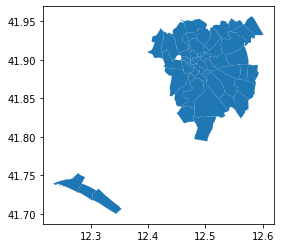

In [43]:
quartieri_totali.plot()

In [44]:
# check for missing values
quartieri_totali.isnull().sum().to_frame()

0
neighbourhood  0
NUMERO         0
MUNICIPIO      0
SEDE_MUNIC     0
POPOLAZIONE    0
SUPERFICIE     0
geometry       0

In [45]:
#create a copy of quartieri_totali: from now I'm going to use this one
quartieri_geo = quartieri_totali.copy()


Having numbers and prefixes (Q_#, R_#) we can distinguish between quartieri e rioni even if this information is not very useful or interesting. Here are all called "neighborhood"

MODIFY MUNICIPIO column: there are some districts that belong to more than one municipality, but in order to have an ovierview of neighborhoods we modify municipi for those districts keepping only one.

In [46]:
# MODIFY MUNICIPIO
municipi_lista = list(quartieri_geo.MUNICIPIO)
m_mun = []
for el in municipi_lista:
  if '-' in el:
    el = el.split('-')[1]
    m_mun.append(el)
  else:
    m_mun.append(el)
quartieri_geo.MUNICIPIO = m_mun

we said that there are 57 districts and now we can see how they are splitted between municipalities: in this way we know how many districts belong to one municipality of reference 

In [47]:
# GROUPBY SEDE MUNICIPIO 
mun_group = quartieri_geo.groupby(['MUNICIPIO']).size().to_frame('size').sort_values(['size', 'MUNICIPIO'], ascending=False).reset_index()
mun_group.rename(columns={'size':'tot_neigh','NUMERO':'NUMERO'},inplace=True)

print(sum(mun_group.tot_neigh)) # check that sum is 57

mun_group

57


MUNICIPIO  tot_neigh
0          I         22
1         II          5
2          X          3
3          V          3
4         IV          3
5       VIII          3
6         IX          2
7        III          2
8        XII          2
9          V          2
10        XV          1
11       XIV          1
12       VII          1
13        XV          1
14       XIV          1
15     XIII           1
16     VIII           1
17       VII          1
18       VI           1
19       III          1

In [48]:
#add name to municipalities to make a plot
def get_mun_name(df,diz):
  names = []
  ord_name = []
  for row in df.iterrows():
    ns = str(row[1]).split()
    ind_mun = ns.index('MUNICIPIO')+1
    ord_name.append(ns[ind_mun])
  
  for el in ord_name:
    df['name'] = ''
    if el in coords:
      names.append(coords[el])
      df['name'] = coords[el]
  df['name'] = names
  #print(names)

get_mun_name(mun_group,coords)

In [49]:
print(sum(mun_group.tot_neigh))
mun_group
mun_group = mun_group.sort_values('tot_neigh',ascending=False).reset_index()
cols = ['MUNICIPIO','tot_neigh','name']
mun_group = mun_group[cols]
mun_group 

57


MUNICIPIO  tot_neigh                    name
0          I         22          Centro Storico
1         II          5       Parioli/Nomentano
2          X          3            Ostia/Acilia
3          V          3   Prenestino/Centocelle
4         IV          3               Tiburtina
5       VIII          3            Appia Antica
6         IX          2                     Eur
7        III          2             Monte Sacro
8        XII          2             Monte Verde
9          V          2   Prenestino/Centocelle
10     XIII           1                 Aurelia
11       VI           1        Roma delle Torri
12       VII          1  San Giovanni/Cinecittà
13     VIII           1            Appia Antica
14        XV          1         Cassia/Flaminia
15       XIV          1             Monte Mario
16        XV          1         Cassia/Flaminia
17       VII          1  San Giovanni/Cinecittà
18       XIV          1             Monte Mario
19       III          1             Monte Sacro

In [50]:
diz = {}
for row in mun_group.iterrows():
    ns = str(row[1]).split()
    
    indx_forname = ns.index('name')
    indx2_forname = ns.index('Name:')
    nome = ' '.join(ns[indx_forname+1 : indx2_forname])
    
    indx_fornumber = ns.index('tot_neigh')
    number = int(ns[indx_fornumber + 1])
    

    if not nome in diz:
      diz[nome] = number
    else:
      diz[nome] += number 


In [51]:
new_diz = sorted(diz.items(), key = lambda x:x[1], reverse = True)


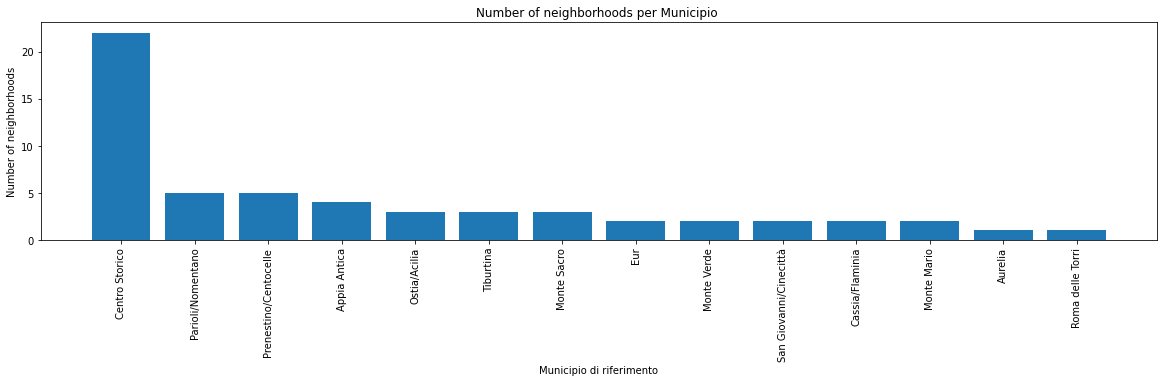

In [52]:
# plot of quartieri grouped per municipio  
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

fig = plt.figure(figsize=(20,4))
xs = np.arange(len(new_diz))
ys = [c[1] for c in new_diz]
plt.bar(xs,ys)
ticks = [c[0] for c in new_diz]

plt.xticks(xs, ticks,rotation=90)
plt.title('Number of neighborhoods per Municipio ')
plt.ylabel('Number of neighborhoods')
plt.xlabel('Municipio di riferimento')
plt.show()

From the barplot we see that municipio I: Centro Storico is the one accounting for most neighborhoods, followed by II:Parioli/Nomentano and V:Prenestino/Centocelle that account for 5 neighb. All others Muinicpi account for 4 or less neighb.


# 1.information about neighboroods

*   population
*   population density
*   school



Now that we know how many districts there are in each municipality and we have all the neighborhoods, we may think to look for information about population, population density and schools in each neighborhood getting some knowledge about life in districts and then chek if districts in MUNICIPIO GROUP involving less district, are those more/less populated

**POPULATION**

In [53]:
# first we look to population
pop = quartieri_geo.sort_values('POPOLAZIONE',ascending=False).reset_index().drop(columns = ['index'])
pop.head(5)


neighbourhood  ...                                           geometry
0  LIDO DI CASTEL FUSANO  ...  POLYGON ((12.35402 41.70634, 12.35362 41.70605...
1              TUSCOLANO  ...  POLYGON ((12.53209 41.86316, 12.53088 41.86589...
2           APPIO LATINO  ...  POLYGON ((12.53402 41.85992, 12.53374 41.85935...
3                TRIESTE  ...  POLYGON ((12.50682 41.91224, 12.50600 41.91294...
4           GIANICOLENSE  ...  POLYGON ((12.47407 41.88314, 12.47268 41.88206...

[5 rows x 7 columns]

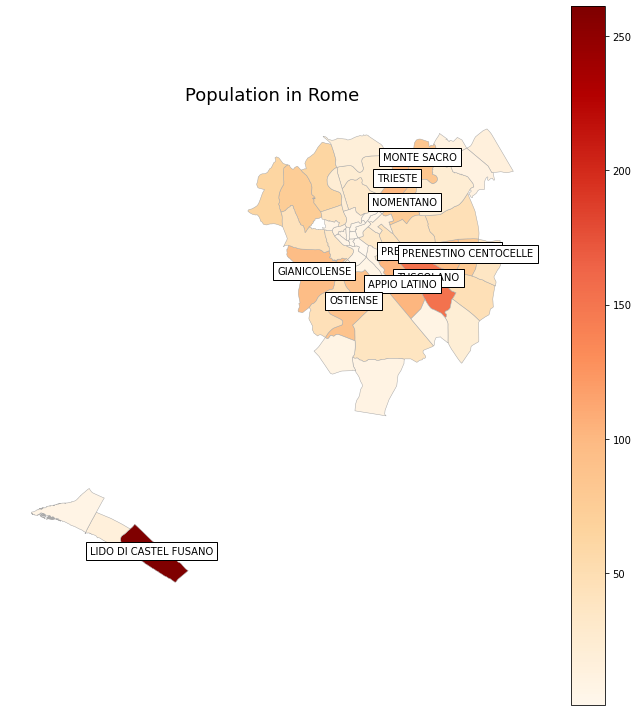

In [54]:
#population in a static map: only the first 10

ax1 = pop.plot(column='POPOLAZIONE',
                  cmap="OrRd", edgecolor = "darkgrey", 
                  linewidth = 0.5,legend=True,figsize=(10,10))

for name, geo in zip(pop.neighbourhood[:10], pop.geometry[:10]): 
  plt.text(geo.centroid.x, geo.centroid.y, name, horizontalalignment='center',bbox=dict(facecolor='white')) 

plt.tight_layout()
ax1.set_axis_off()
ax1.set_title('Population in Rome', fontdict={'fontsize': "18", 'fontweight' : '3'})
plt.show()

Most populated neighborhoods are LIDI DI CASTEL FUSANO (Q_XXXV), TUSCOLANO (Q_VIII), APPIO LATINO (Q_IX)

**POPULATION DENSITY**

In [55]:
quartieri_geo['POP_DENSITY'] = round(quartieri_geo['POPOLAZIONE']/(quartieri_geo['SUPERFICIE']/ 10**6),2) 
quartieri_geo

neighbourhood  ...  POP_DENSITY
0            ALESSANDRINO  ...     99064.61
1           APPIO CLAUDIO  ...     40094.13
2            APPIO LATINO  ...    175247.46
3               DON BOSCO  ...     81401.92
4                  EUROPA  ...     18659.89
5                FLAMINIO  ...    180389.51
6            GIANICOLENSE  ...    123744.37
7             MONTE SACRO  ...    203419.85
8        MONTE SACRO ALTO  ...     58764.65
9        GIULIANO DALMATA  ...     12270.14
10  LIDO DI CASTEL FUSANO  ...    426610.00
11  LIDO DI OSTIA LEVANTE  ...     50527.89
12  LIDO DI OSTIA PONENTE  ...     15634.10
13       APPIO PIGNATELLI  ...     23661.50
14              ARDEATINO  ...  26987637.36
15                AURELIO  ...     95136.02
16              COLLATINO  ...     76455.02
17         DELLA VITTORIA  ...    104039.54
18                PARIOLI  ...     48530.60
19              PIANCIANO  ...     90787.33
20             PIETRALATA  ...     31969.02
21          PONTE MAMMOLO  ...     27877.17
22              PORTUENSE  ...     94183.30
23  PRENESTINO CENTOCELLE  ...    314138.49
24    PRENESTINO LABICANO  ...    218769.05
25             PRIMAVALLE  ...    117810.16
26                SALARIO  ...    347308.32
27            SAN BASILIO  ...     41744.48
28              TIBURTINO  ...    115453.82
29          TOR DI QUINTO  ...     39611.49
30                TRIESTE  ...    280223.57
31              TRIONFALE  ...    122155.82
32              TUSCOLANO  ...    219048.50
33              NOMENTANO  ...    246339.68
34               OSTIENSE  ...    119498.91
35                S. SABA  ...     56758.49
36            SALLUSTIANO  ...    188704.32
37              TESTACCIO  ...    264682.18
38             TRASTEVERE  ...    184950.55
39                  TREVI  ...    134609.69
40                  BORGO  ...    173500.23
41             CAMPITELLI  ...     18868.25
42           CAMPO MARZIO  ...    155007.84
43        CASTRO PRETORIO  ...    161051.16
44                  CELIO  ...     84113.08
45                COLONNA  ...    167071.17
46              ESQUILINO  ...    260699.69
47               LUDOVISI  ...    130583.99
48                  MONTI  ...    182759.22
49                PARIONE  ...    423244.93
50                  PIGNA  ...    134705.33
51                  PONTE  ...    350778.63
52                  PRATI  ...    285312.74
53                 REGOLA  ...    244817.47
54                   RIPA  ...     53275.52
55              S. ANGELO  ...    210960.96
56           S. EUSTACHIO  ...    260035.01

[57 rows x 8 columns]

In [56]:
pop_dens = quartieri_geo.sort_values('POP_DENSITY',ascending=False)
pop_dens[['neighbourhood', 'POPOLAZIONE','POP_DENSITY']].head(10)

neighbourhood  POPOLAZIONE  POP_DENSITY
14              ARDEATINO       39.294  26987637.36
10  LIDO DI CASTEL FUSANO      261.000    426610.00
49                PARIONE        8.139    423244.93
51                  PONTE       11.488    350778.63
26                SALARIO       17.032    347308.32
23  PRENESTINO CENTOCELLE       78.032    314138.49
52                  PRATI       36.948    285312.74
30                TRIESTE      101.525    280223.57
37              TESTACCIO       17.739    264682.18
46              ESQUILINO       42.103    260699.69

We have a different order when considering the covered area from a neighb: ADREATINO, LIDO DI CASTEL FUSANO, PARIONE are the ones with highest population density. 
In particular, the population density of ADREATINO is strongly higher than that of other neighb, even though inhabitants are fewer than those in the other districts, meaning that this is a quite small district (with respect to covered area) with lot of people living here. 
\

### SUMMARIZING RESULTS
### POPULATION                


1.   LIDO DI CASTEL FUSANO
2.   TUSCOLANO
3.   APPIO LATINO

\
### POP DENSITY


1.   ADREATINO
2.   LIDO DI CASTEL FUSANO
3.   PARIONE


To get some other information about neighborhoods in Rome, we look for CSW, WSF and arcgis. 
I find something interesting about schools only with WSF

# Catalogue Web Service - GOV

In [57]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsLike, BBox

In [58]:
csw = CatalogueServiceWeb("http://geodati.gov.it/RNDT/csw")

In [59]:
query = PropertyIsLike('csw:AnyText', 'Roma')


In [60]:
csw.getrecords2(constraints=[query])

In [61]:
for rec in csw.records:
  print(rec + " - " + csw.records[rec].title)

ispra_rm:Meta_Geo_GHS000001_RN - PanGeo Geohzard Roma - Service
agea:00361:20090911:091943 - Ortofotocarta Roma 2008
agea:00212:20090727:104323 - Ortofotocarta Roma 1996
agea:00215:20090727:105030 - Ortofotocarta Roma 2005
agea:00213:20090727:104441 - Ortofotocarta Roma 2001
agea:00214:20090727:104617 - Ortofotocarta Roma 2002
ispra_rm:Meta_Geo_DT000040_RN - PanGeo Geohazard Roma - Dataset
c_a474:e09f1e62-bcf3-4e58-a983-c8305cc4e324 - Assemini: Case storiche via Roma
c_a474:b3750cb9-6099-41a7-a3ed-adeed04a07fe - Assemini: Attivita commerciali via Roma
ispra_rm:01StoricoGEOLOGICA_ROMA_DESTRA_TEVERE_DT - STORICO CARTA GEOLOGICA DINTORNI ROMA DESTRA TEVERE - View Service


from geodati.gov there are not interesting data 
about Rome, so let's check the geoportal for the environment

# Catalogue Web Service - MINISTERO DELL'AMBIENTE

In [62]:
from shapely.geometry import Polygon

In [63]:
csw = CatalogueServiceWeb("http://www.pcn.minambiente.it/geoportal/csw")

In [64]:
# compute bbox
rome_boundary = quartieri_geo.unary_union
bounds = rome_boundary.bounds


In [65]:
query_bbox = BBox(list(bounds)) 

In [66]:
csw.getrecords2(constraints=[query_bbox],maxrecords=250)

In [67]:
csw.results

{'matches': 138, 'nextrecord': 0, 'returned': 138}

In [68]:
for rec in csw.records:
  print(rec + " - " + csw.records[rec].title)

0216c195-60f8-456e-8d2e-1b5e59052268 - Servizio di ricerca del catalogo metadati del Geoportale in Comune
m_amte:299FN3:7c362dc4-47b4-45d3-f23c-a4d2393831ee - DSM FIRST LiDAR con risoluzione a terra 2 metri - Regione Lazio
m_amte:299FN3:6636776d-0c1e-4e48-c094-d0c256bafec8 - DTM LiDAR con risoluzione a terra 2 metri - Regione Lazio
m_amte:299FN3:2714c74a-8cb7-4a0d-cf00-48a2b9fd6f47 - DSM LAST LiDAR con risoluzione a terra 2 metri - Regione Lazio
m_amte:299FN3:65496526-8635-46f7-ac31-ac6772afaef2 - INTENSITY LiDAR con risoluzione a terra 2 metri - Regione Lazio
m_amte:299FN3:b86e27e3-479d-4ec3-d17f-9883bd0495c2 - DTM LiDAR con risoluzione a terra 1 metro - Regione Lazio
m_amte:299FN3:d492d6c1-24ff-477f-b173-4c41937dbd17 - DSM LAST LiDAR con risoluzione a terra 1 metro - Regione Lazio
m_amte:299FN3:d53d84c9-75c5-44fb-9d7e-88f4b22db95f - DSM FIRST LiDAR con risoluzione a terra 1 metro - Regione Lazio
m_amte:299FN3:f412b862-1569-42b9-87db-b97359de67af - INTENSITY LiDAR con risoluzione a te

In [69]:
scuole_id = "m_amte:299FN3:8345a338-17c9-444b-c598-fe508d1cb45e"

In [70]:
record_scuole = csw.records[scuole_id]
record_scuole.abstract

"Localizzazione degli istitui scolastici pubblici  per l'infanzia, primarie e secondarie in base agli indirizzi forniti dal Mistero dell'Istruzione, dell'Università e della Ricerca."

In [71]:
for reference in record_scuole.references:
  print(reference['scheme'])
  print(reference['url'])

urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://www.pcn.minambiente.it/viewer/index.php?services=scuole_statali_paritarie
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Scuole_statali_paritarie.map
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Thumbnail
http://www.pcn.minambiente.it/anteprima/scuole_statali_paritarie.gif
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Document
http://www.pcn.minambiente.it/geoportal/csw?getxml=%7BD3D1C3D8-F2C8-4D7C-A796-C3F1EA45E063%7D
OGC:WMS
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Scuole_statali_paritarie.map
OGC:WFS
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS


In [72]:
from owslib.wfs import WebFeatureService

In [73]:
url_s = 'http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS'

In [74]:
scuole = WebFeatureService(url=url_s,version="1.1.0")


In [75]:
scuole.identification.title

"Scuole pubbliche per l'infanzia, primarie e secondarie sul territorio nazionale"

In [76]:
scuole.contents

{'SPU.SCUOLE.': <owslib.feature.wfs110.ContentMetadata at 0x7f278301e5d0>}

In [77]:
layer_scuole = list(scuole.contents)[0]


In [78]:
# this can take a while to run
response_scuole = scuole.getfeature(typename=layer_scuole, bbox=bounds,srsname='urn:ogc:def:crs:EPSG::4326')


In [79]:
out = open('scuole.gml', 'wb')
out.write(response_scuole.read())
out.close()

In [80]:
#read with geopandas
scuole_gpd = gpd.read_file("scuole.gml")
scuole_gpd.head(3) 

gml_id cod_meccanografico  ...   pec                   geometry
0  SPU.SCUOLE..52307         RM1A058002  ...  None  POINT (41.88110 12.45349)
1  SPU.SCUOLE..52321         RM1A08200V  ...  None  POINT (41.86670 12.44928)
2  SPU.SCUOLE..52323         RM1A08500A  ...  None  POINT (41.86829 12.44733)

[3 rows x 15 columns]

In [81]:
scuole_gpd.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [82]:
# need to change in 4265
scuole_gpd = scuole_gpd.to_crs(epsg=4265)


In [83]:
 scuole_gpd.crs.to_string()

'EPSG:4265'

To perform the spatial join between **scuole_gpd** and **quartieri_geo** we must check:


*   crs: they are equal
*   geometry: need to swap the geometry in the scuole_gpd

REMARK: managin the geometry seems to be not easy since latitude and longitude are 41.916389, 12.453611 respectively. However, having coordinates as lat-lon produce an upsidedown map.

In [84]:
print(" ",scuole_gpd.crs, "\n ", quartieri_geo.crs)

  epsg:4265 
  epsg:4265


In [85]:
# problem of inverted axes in the geometry column
import shapely

In [86]:
def swapxy(geometry):
  geometry = shapely.ops.transform(lambda x, y: (y, x),geometry)
  return geometry



In [87]:
scuole_gpd['geometry'] = scuole_gpd['geometry'].apply(lambda geometry: swapxy(geometry))


In [88]:
# performa the spatial join
geo_scuole = gpd.sjoin(quartieri_geo, 
                      scuole_gpd, how='inner', op='contains', lsuffix='quartieri_', rsuffix='scuole_').reset_index().drop(columns=['index'])
print(geo_scuole.shape)
geo_scuole.head(5)

(1449, 23)


neighbourhood   NUMERO  ...            sito_web   pec
0  ALESSANDRINO  Q_XXIII  ...  www.82cdmarconi.it  None
1  ALESSANDRINO  Q_XXIII  ...  www.82cdmarconi.it  None
2  ALESSANDRINO  Q_XXIII  ...  www.82cdmarconi.it  None
3  ALESSANDRINO  Q_XXIII  ...  www.82cdmarconi.it  None
4  ALESSANDRINO  Q_XXIII  ...                None  None

[5 rows x 23 columns]

In [89]:
print(geo_scuole.shape)
print(scuole_gpd.shape)
print('I have lost %s schools'%(scuole_gpd.shape[0]-geo_scuole.shape[0]))

(1449, 23)
(1975, 15)
I have lost 526 schools


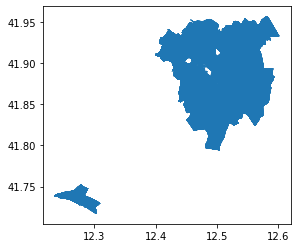

In [90]:
geo_scuole.plot()

In [91]:
geo_scuole.isnull().sum().to_frame()

0
neighbourhood               0
NUMERO                      0
MUNICIPIO                   0
SEDE_MUNIC                  0
POPOLAZIONE                 0
SUPERFICIE                  0
geometry                    0
POP_DENSITY                 0
index_scuole_               0
gml_id                      0
cod_meccanografico          0
denominazione               1
tipo_scuola                 0
indirizzo                   4
comune                      0
cap                         0
telefono                  278
fax                       425
cod_istituto_principale     0
statale                     0
email                      85
sito_web                  831
pec                      1212

In [92]:
#filter columns
cols = ['neighbourhood', 'NUMERO', 'MUNICIPIO', 'SEDE_MUNIC',
        'POPOLAZIONE', 'SUPERFICIE', 'geometry', 'POP_DENSITY',
        'denominazione', 'tipo_scuola', 'indirizzo', 'statale']
geo_scuole = geo_scuole[cols]
geo_scuole.head(5)

neighbourhood   NUMERO  ...                indirizzo  statale
0  ALESSANDRINO  Q_XXIII  ...          VIA BONAFEDE,95  STATALE
1  ALESSANDRINO  Q_XXIII  ...        VIA DEI SALICI 27  STATALE
2  ALESSANDRINO  Q_XXIII  ...       VIA DEI SALICI, 27  STATALE
3  ALESSANDRINO  Q_XXIII  ...  VIALE ALESSANDRINO, 390  STATALE
4  ALESSANDRINO  Q_XXIII  ...   VIALE ALESSANDRINO,390  STATALE

[5 rows x 12 columns]

Here we find information about different **grades of schools**: SCUOLA PRIMARIA, SCUOLA SECONDARIA DI SECONDO GRADO, SCUOLA DELL'INFANZIA, SCUOLA SECONDARIA DI PRIMO GRADO. 

In [93]:
typesc = geo_scuole.groupby(["tipo_scuola"]).size().to_frame("types").sort_values('types',ascending=False).reset_index()
print('In Rome there are %s schools'%(sum(typesc.types)))
typesc

In Rome there are 1449 schools


tipo_scuola  types
0                SCUOLA DELL'INFANZIA    522
1                     SCUOLA PRIMARIA    402
2  SCUOLA SECONDARIA DI SECONDO GRADO    368
3    SCUOLA SECONDARIA DI PRIMO GRADO    157

In [94]:
sch = geo_scuole.groupby(["neighbourhood", "tipo_scuola"]).size().to_frame("n_scuole").sort_values('n_scuole',ascending=False).reset_index()
print(sum(sch.n_scuole))
sch.head()

1449


neighbourhood                         tipo_scuola  n_scuole
0  PRENESTINO LABICANO                SCUOLA DELL'INFANZIA        58
1  PRENESTINO LABICANO                     SCUOLA PRIMARIA        42
2  PRENESTINO LABICANO  SCUOLA SECONDARIA DI SECONDO GRADO        38
3            TUSCOLANO  SCUOLA SECONDARIA DI SECONDO GRADO        31
4         GIANICOLENSE                SCUOLA DELL'INFANZIA        27

In [95]:
#first we see how many schools are present in each district
sch_tot = geo_scuole.groupby(["neighbourhood"]).size().to_frame("tot_schools").sort_values('tot_schools',ascending=False).reset_index()
print(sum(sch_tot.tot_schools))
sch_tot.head()

1449


neighbourhood  tot_schools
0  PRENESTINO LABICANO          154
1            TUSCOLANO           86
2            ARDEATINO           65
3         GIANICOLENSE           60
4              TRIESTE           59

From **sch_tot** we see how many schools, for each type of school, there are in each district 


We previously said that most populated districts are: LIDO DI CASTEL FUSANO, TUSCOLANO, APPIO LATINO but in LIDO DI CASTEL FUSANO and now we can try to compute how many schools there are in these three districts.

In [96]:
sch_tot[sch_tot['neighbourhood']=='LIDO DI CASTEL FUSANO']

Empty DataFrame
Columns: [neighbourhood, tot_schools]
Index: []

In LIDO DI CASTEL FUSANO there isn't any schools. This is not strange since LIDO DI CASTEL FUSANO is a place for turists.

In [97]:
sch_tot[sch_tot['neighbourhood']=='TUSCOLANO']

neighbourhood  tot_schools
1     TUSCOLANO           86

In [98]:
sch[sch['neighbourhood'] =='TUSCOLANO' ]

neighbourhood                         tipo_scuola  n_scuole
3      TUSCOLANO  SCUOLA SECONDARIA DI SECONDO GRADO        31
6      TUSCOLANO                SCUOLA DELL'INFANZIA        25
9      TUSCOLANO                     SCUOLA PRIMARIA        21
58     TUSCOLANO    SCUOLA SECONDARIA DI PRIMO GRADO         9

In [99]:
sch_tot[sch_tot['neighbourhood']=='APPIO LATINO']

neighbourhood  tot_schools
13  APPIO LATINO           37

In [100]:
sch[sch['neighbourhood'] =='APPIO LATINO' ]

neighbourhood                         tipo_scuola  n_scuole
24   APPIO LATINO                SCUOLA DELL'INFANZIA        15
54   APPIO LATINO  SCUOLA SECONDARIA DI SECONDO GRADO         9
64   APPIO LATINO                     SCUOLA PRIMARIA         8
104  APPIO LATINO    SCUOLA SECONDARIA DI PRIMO GRADO         5

In [101]:
sch_tot[sch_tot['neighbourhood']=='PRENESTINO LABICANO']

neighbourhood  tot_schools
0  PRENESTINO LABICANO          154

In [102]:
sch[sch['neighbourhood'] =='PRENESTINO LABICANO' ]

neighbourhood                         tipo_scuola  n_scuole
0   PRENESTINO LABICANO                SCUOLA DELL'INFANZIA        58
1   PRENESTINO LABICANO                     SCUOLA PRIMARIA        42
2   PRENESTINO LABICANO  SCUOLA SECONDARIA DI SECONDO GRADO        38
23  PRENESTINO LABICANO    SCUOLA SECONDARIA DI PRIMO GRADO        16

### SUMMARIZING RESULTS

1.   PRENESTINO LABICANO: 	154 schools
2.   TUSCOLANO: 86 schools
3.   APPIO LATINO: 37 schools

We may suppose that many families with children like to place in these neighbors since the presence of many schools. At the same time they seem to prefer to settle in TUSCOLANO or APPIO LATINO that we said are most populated ones.





# 2.identify which are neighborhoods with highest prices

In order to have information about prices, we need to perform a spatial join between the rome_listing_geo that contains prices data and quartieri_geo that contains all the 57 neighborhoods (instead of the only 15 accounted in the rome_listing_geo)





1.   Perform the spatial join 
2.   Visualize price distribution of rooms
3.   Visualize location of high/low price rooms
3.   Groupby neighborhoods and compute median price for each --> neigb with median price > split value are those with highest price



In [103]:
print(" ",rome_listings_geo.crs, "\n ", quartieri_geo.crs)

  EPSG:4265 
  epsg:4265


In [104]:
#perform spatial join
listing_join = gpd.sjoin(quartieri_geo,rome_listings_geo, op='contains').reset_index().drop(columns=['index','index_right','neighbourhood_right'])
print(listing_join.shape)
listing_join['geometry'] = gpd.points_from_xy(listing_join.longitude,listing_join.latitude)
listing_join.head()

(25420, 15)


neighbourhood_left   NUMERO MUNICIPIO  ...        room_type  price  minimum_nights
0       ALESSANDRINO  Q_XXIII         V  ...     Private room     23               1
1       ALESSANDRINO  Q_XXIII         V  ...  Entire home/apt     80               2
2       ALESSANDRINO  Q_XXIII         V  ...     Private room     15               2
3       ALESSANDRINO  Q_XXIII         V  ...  Entire home/apt    150               2
4       ALESSANDRINO  Q_XXIII         V  ...  Entire home/apt     41               3

[5 rows x 15 columns]

In [105]:
listing_join.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [106]:
listing_join.isnull().sum().to_frame()

0
neighbourhood_left   0
NUMERO               0
MUNICIPIO            0
SEDE_MUNIC           0
POPOLAZIONE          0
SUPERFICIE           0
geometry             0
POP_DENSITY          0
name                 4
host_name           11
latitude             0
longitude            0
room_type            0
price                0
minimum_nights       0

In [107]:
cols = [ 'neighbourhood_left', 'name', 'host_name', 
         'room_type','price','minimum_nights', 'geometry']

listing_join = listing_join[cols]
listing_join.rename(columns={'neighbourhood_left':'neighbourhood'},inplace=True)

listing_join.head()

neighbourhood  ...                   geometry
0  ALESSANDRINO  ...  POINT (12.57997 41.87050)
1  ALESSANDRINO  ...  POINT (12.57841 41.87192)
2  ALESSANDRINO  ...  POINT (12.57481 41.87338)
3  ALESSANDRINO  ...  POINT (12.57425 41.87394)
4  ALESSANDRINO  ...  POINT (12.57403 41.87428)

[5 rows x 7 columns]

In [108]:
listing_join.price.describe()

count    25420.000000
mean       107.357710
std        354.211939
min          0.000000
25%         46.000000
50%         68.000000
75%        100.000000
max      10571.000000
Name: price, dtype: float64

There is something strange: the minimum price is 0 and it is quite impossible that someone gives a room for free --> drop rows with price equal to zero

In [109]:
listing_join[listing_join['price'] == 0]


neighbourhood  ...                   geometry
14310            TREVI  ...  POINT (12.48266 41.89745)
16939  CASTRO PRETORIO  ...  POINT (12.50250 41.90338)
19786         LUDOVISI  ...  POINT (12.49210 41.90964)
20825            MONTI  ...  POINT (12.48806 41.89370)
21613            MONTI  ...  POINT (12.49292 41.89960)

[5 rows x 7 columns]

In [110]:
# Drop rows
listing_join = listing_join[listing_join['price'] !=0]
listing_join.price.describe()

count    25415.000000
mean       107.378831
std        354.243580
min          7.000000
25%         46.000000
50%         68.000000
75%        100.000000
max      10571.000000
Name: price, dtype: float64

Now the minimum price is 7 euros that, although it is a very low price, it is different from zero.

Since the 75% percentiles account for a price of 100€ and the max price is 10571.00€ (very expensive room), to plot the price distribution it is reasonable to better chek the price distribution and to choose a proper range for the price distribution plot. 


In [111]:
# Compare mean and median
avg = round(listing_join.price.mean(),2)
median = round(listing_join.price.median(),2)

print('the average price for a room in rome is %s€ \n'%(avg))
print('the median price for a room in rome is %s€ \n'%(median))
print('the highest price is %s€ \n'%(max(listing_join.price)))
print('the lowest price is %s€ \n'%(min(listing_join.price)))

the average price for a room in rome is 107.38€ 

the median price for a room in rome is 68.0€ 

the highest price is 10571€ 

the lowest price is 7€ 



In [112]:
# interval accounts for prices in a range(median, mean)
interval = listing_join[(listing_join.price >= median) & (listing_join.price <= avg)]
interval.shape[0]
# in this price range there are 7.365 rooms, meaning that there are other 12.649 rooms with a price lower than the median. 
print('there are %s rooms with a price between %s and %s euros'%(interval.shape[0], median, avg))

there are 7364 rooms with a price between 68.0 and 107.38 euros


In [113]:
interval.price.describe()

count    7364.000000
mean       83.773900
std        11.158864
min        68.000000
25%        75.000000
50%        80.000000
75%        93.000000
max       107.000000
Name: price, dtype: float64

Mean is greater the median value (and there is a  high standard deviation) meaning that almost half of the sample observations fall at the left of the mean, that is there are more structures offering rooms for prices less than 107.37€, and within these structures, there are more with prices under the median price. So given the very skewed distribution, I will use the median for the further considerations.

In [114]:
above_median = listing_join[listing_join['price'] > median]
under_median = listing_join[listing_join['price'] <= median]
print('there are %s rooms that cost more than the median price'%(above_median.shape[0]))
print('there are %s rooms that cost less than the median price'%(under_median.shape[0]))


there are 12634 rooms that cost more than the median price
there are 12781 rooms that cost less than the median price


Text(0.5, 1.0, 'UNDER MEDIAN PRICE DISTRIBUTION')

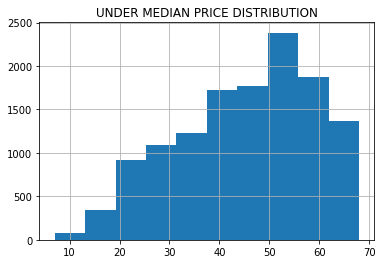

In [115]:
title = 'UNDER MEDIAN PRICE DISTRIBUTION' 
under_median.price.hist().set_title(title)

Text(0.5, 1.0, 'ABOVE MEDIAN PRICE DISTRIBUTION')

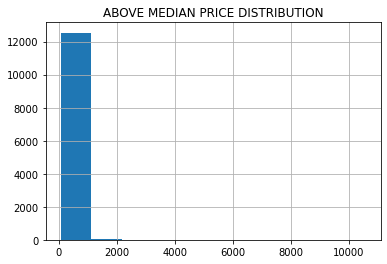

In [116]:
title = 'ABOVE MEDIAN PRICE DISTRIBUTION' 
above_median.price.hist().set_title(title)

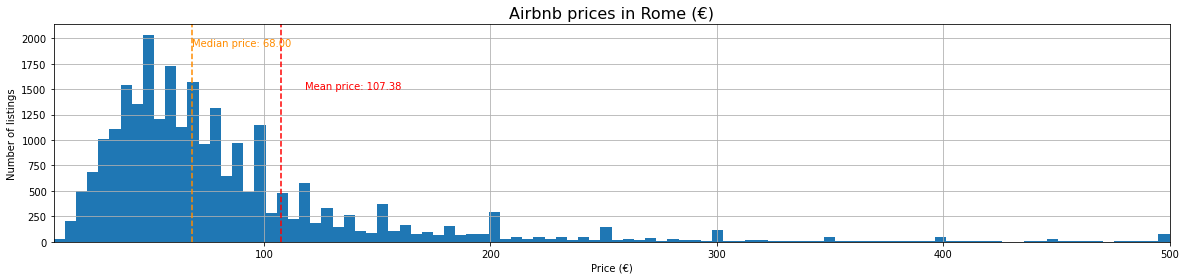

In [117]:
#visualize price distribution
def plot_price_distribution():
    """
    function that plots the distribution of the price only up to 500€
    (using higher upper bound the distribution is definetly skewed)
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,4))

    # fino a 500€
    listing_join.price.hist(bins=100, range=(min(listing_join.price),500)) 
    plt.margins(x=0)
    plt.title("Airbnb prices in Rome (€)", fontsize=16)
    plt.xlabel("Price (€)")
    plt.ylabel("Number of listings")
    plt.axvline(listing_join['price'].median(), color='darkorange', linestyle='--') #most listings have a price below 
    plt.axvline(listing_join['price'].mean(), color='red', linestyle='--') #most listings have a price below 

    min_ylim, max_ylim = plt.ylim()
    plt.text(listing_join['price'].median()*1, max_ylim*0.9,'Median price: {:.2f}'.format(listing_join['price'].median()),color='darkorange')
    plt.text(listing_join['price'].mean()*1.1, max_ylim*0.7, 'Mean price: {:.2f}'.format(listing_join['price'].mean()),color = 'red')
    plt.show()
    #heavy tailed prices 



plot_price_distribution()

In [118]:
import mapclassify
mapclassify.Percentiles(listing_join.price)
#1, 10, 50, 90, 99, 100  percentiles.


Percentiles                 

      Interval         Count
----------------------------
[    7.00,    17.00] |   277
(   17.00,    32.00] |  2288
(   32.00,    68.00] | 10216
(   68.00,   160.00] | 10138
(  160.00,   600.00] |  2243
(  600.00, 10571.00] |   253

From percentiles distribution we see that most of structures offer price between 32€ and 160€, so that to find neihgborhoods with higest prices it is reasonable to split observation according to the 75 percentiles. 

Neighborhoods for which the median price of all available rooms is higher than the split value are those with higher prices.

We have first a visualization of distribution of high and low prices rooms in the city.

In [119]:
#define the split value
split_75 =  listing_join.price.quantile(0.75)
split_75

100.0

In [120]:
#rooms with price < split_value
low_price = listing_join[listing_join.price < split_75]
cols = ['neighbourhood', 'name', 'host_name', 'room_type', 'price',
       'minimum_nights', 'geometry']
low_price = low_price[cols]
print(low_price.shape[0]) # 23038
low_price.head(3)

18923


neighbourhood  ...                   geometry
0  ALESSANDRINO  ...  POINT (12.57997 41.87050)
1  ALESSANDRINO  ...  POINT (12.57841 41.87192)
2  ALESSANDRINO  ...  POINT (12.57481 41.87338)

[3 rows x 7 columns]

In [121]:
#rooms with price > split_value
high_price = listing_join[listing_join.price >= split_75]
print(high_price.shape[0])
cols = ['neighbourhood', 'name', 'host_name', 'room_type', 'price',
       'minimum_nights', 'geometry']
       
high_ = high_price[cols] #6492 
high_price.head() 

6492


neighbourhood  ...                   geometry
3    ALESSANDRINO  ...  POINT (12.57425 41.87394)
20   ALESSANDRINO  ...  POINT (12.57913 41.87638)
46  APPIO CLAUDIO  ...  POINT (12.55552 41.83683)
47  APPIO CLAUDIO  ...  POINT (12.55414 41.83755)
59  APPIO CLAUDIO  ...  POINT (12.56575 41.85187)

[5 rows x 7 columns]

In [122]:
high_price = gpd.GeoDataFrame(high_price, crs = 'EPSG:4265', geometry = high_price.geometry)
low_price= gpd.GeoDataFrame(low_price, crs = 'EPSG:4265', geometry = low_price.geometry)

Text(0.5, 1.0, 'High prices Distribution of Airbnbs')

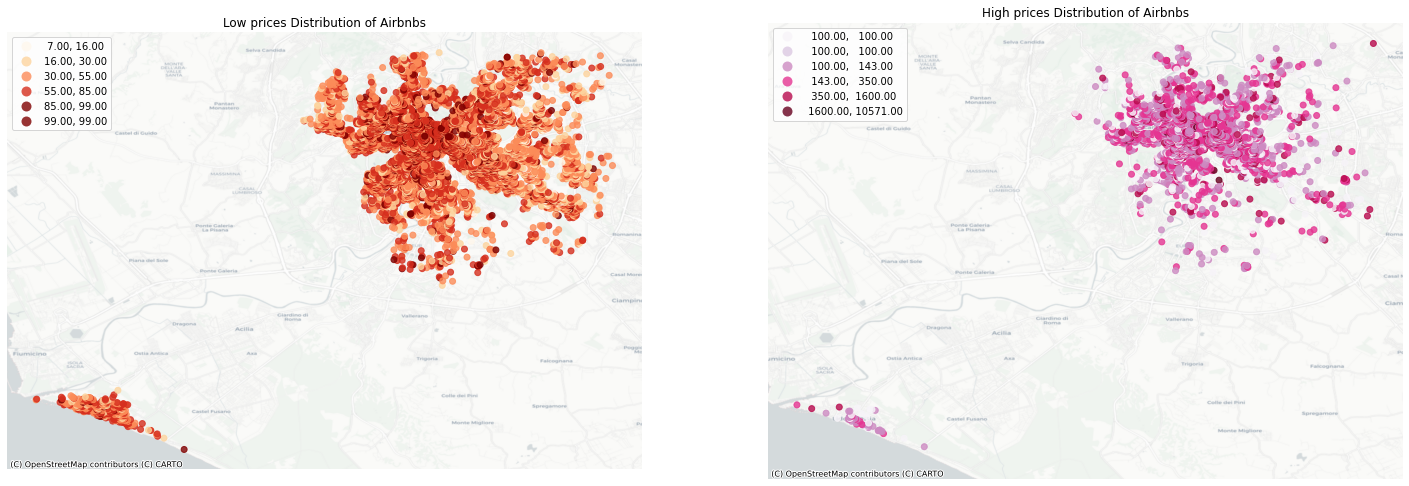

In [123]:
#visualize location high/low price rooms
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize= (25,20))

low_price.to_crs(epsg = 4265).plot(column='price', alpha =0.8,
                                    edgecolor= None,
                                    cmap= 'OrRd',legend =True,
                                    scheme="percentiles", 
                                    ax = ax1)

high_price.to_crs(epsg = 4265).plot(column= 'price',
                                    alpha =0.8,edgecolor= None,
                                    cmap= 'PuRd', figsize=(11,18),
                                    legend =True,
                                    scheme="percentiles",
                                    ax = ax2)

ctx.add_basemap(ax1,
                crs = low_price.to_crs(epsg=4265).crs.to_string(),
                source = ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2,
                crs = high_price.to_crs(epsg = 4265).crs.to_string(),
                source = ctx.providers.CartoDB.Positron)

ax1.set_axis_off()
ax1.set_title('Low prices Distribution of Airbnbs')
ax2.set_axis_off()
ax2.set_title('High prices Distribution of Airbnbs')

It seems that rooms with higher prices are concentrated most in the city centre while rooms with lower prices are spread almost in all the city. This suggest that there may be a relation for prices between neighbors in the centre but the location seems to not affect much the price.

Now I want to see how many available rooms there are in each neighborhood


In [124]:
# groupby
gr = listing_join.groupby('neighbourhood').size().to_frame('tot_rooms').sort_values(['tot_rooms', 'neighbourhood'], ascending=False).reset_index()
gr.head()

neighbourhood  tot_rooms
0     ESQUILINO       1953
1         MONTI       1788
2    TRASTEVERE       1565
3         PRATI       1390
4       AURELIO       1358


**REMARK** : use the median to calculate the price for the reasons previuosly explained -->  very skewed distribution.

In [125]:
#group by neighborhood and compute median price.
prices = round(listing_join.groupby(by=['neighbourhood']).price.median(), 2)  
prices = prices.to_frame('median_price').sort_values('median_price', ascending = False).reset_index()
prices.head()

neighbourhood  median_price
0         PIGNA         116.0
1  CAMPO MARZIO         115.0
2         TREVI         106.0
3     S. ANGELO         105.0
4       COLONNA         104.0

**most expensive neighborhoods in Rome**

In [126]:
prices[prices.median_price > split_75]

neighbourhood  median_price
0         PIGNA         116.0
1  CAMPO MARZIO         115.0
2         TREVI         106.0
3     S. ANGELO         105.0
4       COLONNA         104.0

PIGNA, CAMPO MARZIO, S.ANGELO, TREVI, COLONNA are the most expensive neighbourhoods.


*   See how many rooms are available in each of the 4 most expensive neighborhoods



In [127]:
gr[gr.neighbourhood == 'PIGNA']

neighbourhood  tot_rooms
34         PIGNA        189

In [128]:
gr[gr.neighbourhood == 'CAMPO MARZIO']

neighbourhood  tot_rooms
6  CAMPO MARZIO       1171

In [129]:
gr[gr.neighbourhood == 'TREVI']

neighbourhood  tot_rooms
22         TREVI        309

In [130]:
gr[gr.neighbourhood == 'S. ANGELO']

neighbourhood  tot_rooms
42     S. ANGELO        111

In [131]:
gr[gr.neighbourhood == 'COLONNA']

neighbourhood  tot_rooms
20       COLONNA        353

### SUMMARIZING RESULTS
PIGNA, CAMPO MARZIO, S.ANGELO, TREVI, COLONNA are the most expensive neighbourhoods.\
CAMPO MARZIO is the one with highest number of rooms (1171) and one of the most expensive neighbors. The others account  for less than 1000 rooms.


For further analysis it will be useful to have a full dataset with the 57 neighborhoods and all the attributes found before. Althought in this way we lose information about single rooms (points), they can be found in the listing_jeo dataset (in which there are POINTs instead of POLYGONs)

In [132]:
# new prices
prices = pd.merge(prices, quartieri_geo, on='neighbourhood')
prices

neighbourhood  ...  POP_DENSITY
0                   PIGNA  ...    134705.33
1            CAMPO MARZIO  ...    155007.84
2                   TREVI  ...    134609.69
3               S. ANGELO  ...    210960.96
4                 COLONNA  ...    167071.17
5            S. EUSTACHIO  ...    260035.01
6               PIANCIANO  ...     90787.33
7                   PONTE  ...    350778.63
8                  REGOLA  ...    244817.47
9                 PARIONE  ...    423244.93
10               LUDOVISI  ...    130583.99
11            SALLUSTIANO  ...    188704.32
12             CAMPITELLI  ...     18868.25
13                  BORGO  ...    173500.23
14                PARIOLI  ...     48530.60
15                  PRATI  ...    285312.74
16                  CELIO  ...     84113.08
17             TRASTEVERE  ...    184950.55
18                  MONTI  ...    182759.22
19       GIULIANO DALMATA  ...     12270.14
20                S. SABA  ...     56758.49
21                   RIPA  ...     53275.52
22       APPIO PIGNATELLI  ...     23661.50
23  LIDO DI CASTEL FUSANO  ...    426610.00
24               FLAMINIO  ...    180389.51
25              TESTACCIO  ...    264682.18
26         DELLA VITTORIA  ...    104039.54
27              TRIONFALE  ...    122155.82
28                SALARIO  ...    347308.32
29                 EUROPA  ...     18659.89
30                AURELIO  ...     95136.02
31          TOR DI QUINTO  ...     39611.49
32  LIDO DI OSTIA LEVANTE  ...     50527.89
33           GIANICOLENSE  ...    123744.37
34                TRIESTE  ...    280223.57
35        CASTRO PRETORIO  ...    161051.16
36  LIDO DI OSTIA PONENTE  ...     15634.10
37          APPIO CLAUDIO  ...     40094.13
38           APPIO LATINO  ...    175247.46
39              ESQUILINO  ...    260699.69
40              NOMENTANO  ...    246339.68
41               OSTIENSE  ...    119498.91
42              TUSCOLANO  ...    219048.50
43             PRIMAVALLE  ...    117810.16
44              PORTUENSE  ...     94183.30
45       MONTE SACRO ALTO  ...     58764.65
46            MONTE SACRO  ...    203419.85
47              DON BOSCO  ...     81401.92
48              ARDEATINO  ...  26987637.36
49             PIETRALATA  ...     31969.02
50              TIBURTINO  ...    115453.82
51              COLLATINO  ...     76455.02
52    PRENESTINO LABICANO  ...    218769.05
53          PONTE MAMMOLO  ...     27877.17
54  PRENESTINO CENTOCELLE  ...    314138.49
55           ALESSANDRINO  ...     99064.61
56            SAN BASILIO  ...     41744.48

[57 rows x 9 columns]

Now create the dataframe, then grodataframe, that cotains also information about schools found before, so it contains:
- neighborhoods name
- number of schools (tot_schools)
- median price 
- population 
- area
- population density (pop_density)
- geometry

In [133]:
merging_neigh = pd.merge(sch_tot, prices, how='inner', left_on='neighbourhood', right_on='neighbourhood').reset_index().drop(columns=['index'])
merging_neigh = merging_neigh[['neighbourhood','tot_schools','median_price','POPOLAZIONE','SUPERFICIE','POP_DENSITY','geometry']]
merging_neigh = merging_neigh.rename(columns = {'POPOLAZIONE': 'population', 'SUPERFICIE':'area','POP_DENSITY':'pop_density' })
merging_neigh

neighbourhood  ...                                           geometry
0     PRENESTINO LABICANO  ...  POLYGON ((12.51540 41.89155, 12.51561 41.89178...
1               TUSCOLANO  ...  POLYGON ((12.53209 41.86316, 12.53088 41.86589...
2               ARDEATINO  ...  POLYGON ((12.54069 41.83374, 12.54039 41.83356...
3            GIANICOLENSE  ...  POLYGON ((12.47407 41.88314, 12.47268 41.88206...
4                 TRIESTE  ...  POLYGON ((12.50682 41.91224, 12.50600 41.91294...
5              PRIMAVALLE  ...  POLYGON ((12.42971 41.93636, 12.42939 41.93616...
6               DON BOSCO  ...  POLYGON ((12.58779 41.86772, 12.58748 41.86767...
7               COLLATINO  ...  POLYGON ((12.54202 41.89203, 12.54200 41.89227...
8                OSTIENSE  ...  POLYGON ((12.49841 41.85997, 12.49833 41.85959...
9               NOMENTANO  ...  POLYGON ((12.50172 41.90887, 12.50179 41.90892...
10            MONTE SACRO  ...  POLYGON ((12.54379 41.92833, 12.54374 41.92788...
11              TRIONFALE  ...  POLYGON ((12.45575 41.90687, 12.45566 41.90675...
12  LIDO DI OSTIA PONENTE  ...  POLYGON ((12.27873 41.75289, 12.27929 41.75222...
13           APPIO LATINO  ...  POLYGON ((12.53402 41.85992, 12.53374 41.85935...
14  PRENESTINO CENTOCELLE  ...  POLYGON ((12.55931 41.89421, 12.56084 41.89423...
15              PORTUENSE  ...  POLYGON ((12.47753 41.86332, 12.47723 41.86229...
16         DELLA VITTORIA  ...  POLYGON ((12.47098 41.91817, 12.47071 41.91620...
17                AURELIO  ...  POLYGON ((12.46147 41.88771, 12.46049 41.88743...
18          APPIO CLAUDIO  ...  POLYGON ((12.57572 41.84790, 12.57508 41.84712...
19                 EUROPA  ...  POLYGON ((12.48109 41.83541, 12.48111 41.83382...
20          PONTE MAMMOLO  ...  POLYGON ((12.58712 41.92774, 12.58678 41.92770...
21            SAN BASILIO  ...  POLYGON ((12.60140 41.93272, 12.60077 41.93260...
22       GIULIANO DALMATA  ...  POLYGON ((12.51845 41.82617, 12.51848 41.82608...
23  LIDO DI OSTIA LEVANTE  ...  POLYGON ((12.30986 41.72993, 12.30922 41.72949...
24                  MONTI  ...  POLYGON ((12.49439 41.88997, 12.49326 41.89037...
25             TRASTEVERE  ...  POLYGON ((12.47995 41.88765, 12.47982 41.88684...
26                PARIOLI  ...  POLYGON ((12.50948 41.93280, 12.50945 41.93226...
27       MONTE SACRO ALTO  ...  POLYGON ((12.56602 41.94583, 12.56544 41.94557...
28              ESQUILINO  ...  POLYGON ((12.51596 41.89221, 12.51561 41.89178...
29           ALESSANDRINO  ...  POLYGON ((12.59346 41.88314, 12.59340 41.88295...
30             PIETRALATA  ...  POLYGON ((12.57136 41.92402, 12.57128 41.92385...
31                  PRATI  ...  POLYGON ((12.45575 41.90687, 12.45553 41.90808...
32              PIANCIANO  ...  POLYGON ((12.49863 41.91886, 12.49805 41.91835...
33              TIBURTINO  ...  POLYGON ((12.50756 41.90238, 12.50744 41.90223...
34           CAMPO MARZIO  ...  POLYGON ((12.48865 41.90864, 12.48757 41.90814...
35          TOR DI QUINTO  ...  POLYGON ((12.50272 41.94565, 12.50264 41.94471...
36        CASTRO PRETORIO  ...  POLYGON ((12.50498 41.90745, 12.50842 41.90850...
37       APPIO PIGNATELLI  ...  POLYGON ((12.55184 41.83542, 12.55142 41.83552...
38              TESTACCIO  ...  POLYGON ((12.48138 41.87546, 12.48118 41.87541...
39                   RIPA  ...  POLYGON ((12.48954 41.88425, 12.48913 41.88367...
40               FLAMINIO  ...  POLYGON ((12.47209 41.90998, 12.47180 41.91081...
41                  TREVI  ...  POLYGON ((12.48366 41.89501, 12.48327 41.89493...
42               LUDOVISI  ...  POLYGON ((12.49916 41.90993, 12.49836 41.90976...
43                  BORGO  ...  POLYGON ((12.46859 41.90141, 12.46629 41.90113...
44           S. EUSTACHIO  ...  POLYGON ((12.47620 41.89338, 12.47603 41.89338...
45              S. ANGELO  ...  POLYGON ((12.48071 41.89403, 12.48046 41.89379...
46                S. SABA  ...  POLYGON ((12.48137 41.87590, 12.48109 41.87611...
47                PARIONE  ...  POLYGON ((12.47453 41.89387, 12.47444 41.893

In [134]:
# transform in a geodataframe with the 4265 crs
merging_neigh = gpd.GeoDataFrame(merging_neigh,
                               crs = 'EPSG:4265')
merging_neigh.head()

neighbourhood  ...                                           geometry
0  PRENESTINO LABICANO  ...  POLYGON ((12.51540 41.89155, 12.51561 41.89178...
1            TUSCOLANO  ...  POLYGON ((12.53209 41.86316, 12.53088 41.86589...
2            ARDEATINO  ...  POLYGON ((12.54069 41.83374, 12.54039 41.83356...
3         GIANICOLENSE  ...  POLYGON ((12.47407 41.88314, 12.47268 41.88206...
4              TRIESTE  ...  POLYGON ((12.50682 41.91224, 12.50600 41.91294...

[5 rows x 7 columns]

In [135]:
merging_neigh.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [136]:
# plot median prices in a web map
import folium
from branca.element import Figure       
fig2 = Figure(width=550,height=350)
m2 = folium.Map(location=[ 41.93344, 12.50929,], zoom_start=10)

folium.Choropleth(
    geo_data = merging_neigh.to_json(),
    data = merging_neigh, 
    columns=['neighbourhood', 'median_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='OrRd', 
    fill_opacity=0.7, 
    line_opacity=1,
    legend_name='Median price of Airbnb by Neighbourhood',
    smooth_factor=0).add_to(m2)

folium.features.GeoJson(merging_neigh,
                        name='Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'median_price'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m2)

fig2.add_child(m2)
m2

In [137]:
sorting = merging_neigh.sort_values(by='median_price',ascending = False)

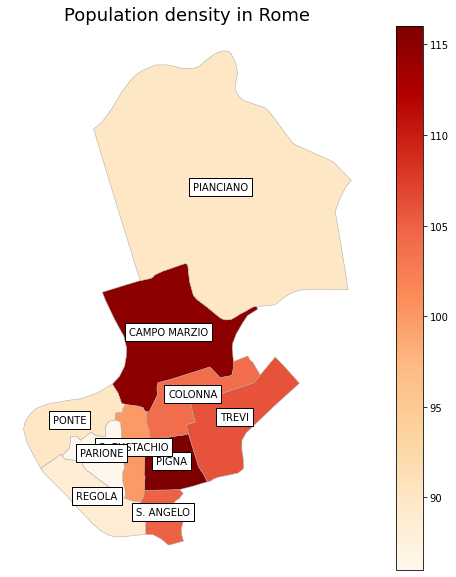

In [138]:
# plot only the 10 most expensive
ax3 = sorting[:10].plot(column='median_price',
                  cmap="OrRd", edgecolor = "darkgrey", 
                  linewidth = 0.5,legend=True,figsize=(10,10))


for name, geo in zip(sorting.neighbourhood[:10], sorting.geometry[:10]): 
  plt.text(geo.centroid.x, geo.centroid.y, name, horizontalalignment='center',bbox=dict(facecolor='white')) 

ax3.set_title('Population density in Rome', fontdict={'fontsize': "18", 'fontweight' : '3'})

ax3.set_axis_off()
plt.show()


**REMARK** : an improvement for this point of the analysis could be to segment the rooms by their type and make price analysis on each segments. For space reasons, this is not done here. 

# 3.identify which are the districts with the greatest number of tourist activities (city data portal and/or openstreetmap)



*   Arcgis server 
*   retrieve data from OpenStreetMap (create a geometry of the city, create a bounnding box, import it to HOT EXPORT TOOL (osm.pbf) and download it (it is already provided):

    - Select points of interest and visualize them in a map
    - spatial join between points of interest (pois_rome_turism) and neighborhoods (merging_neigh)
    - compute number of tourist activites per neighbor and visualize numbers on a web map










I first tried to get tourism information through arcgis server, however this does not give back any data (uncomment to check)

In [139]:
#import os
#os.environ['RESTAPI_USE_ARCPY'] = 'FALSE'
#import restapi

In [140]:
#rest_url = 'https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services'
#ags = restapi.ArcServer(rest_url)
#ags.services

In [141]:
# se non va, runnare di nuovo
#tur = ags.getService('ComuniTurismo')
#tur.list_layers() 

In [142]:
#turismo = tur.layer('ComuniTurismo')


In [143]:
#turismo.export_layer('turismo.shp', outSR=4326) 


In [144]:
#turismo_gpd = gpd.read_file('turismo.shp')
#turismo_gpd.head()

Since I didn't get back data, now I'm going to use the pbf file obtained with HOT EXPORT TOOL

In [145]:
import pyrosm
from pyrosm import OSM


In [146]:
path_pbf = '/content/drive/MyDrive/Colab Notebooks/final_rome.osm.pbf'

In [147]:
merge_box = merging_neigh.copy()

In [148]:
merge_box['territorio'] = 'Roma'
merge_box = merge_box[['territorio', 'geometry']]
merge_box = merge_box.to_crs(epsg=4326).dissolve(by='territorio')
merge_box = list(merge_box.geometry.bounds.values[0])

In [149]:
merge_box

[12.23446054417021, 41.717512894819194, 12.601221351398573, 41.95739316110719]

In [150]:
# create the dataframe with point of interest
osm = pyrosm.OSM(path_pbf,bounding_box=merge_box)


In [151]:
from pyrosm import get_data
import numpy as np

Now it is created a filter to select only information and data abount tourist activites

In [152]:
#select tourism points of interest 
custom_filter = {'tourism': True} 
pois_tourism = osm.get_pois(custom_filter=custom_filter)
pois_tourism = pois_tourism.set_crs(epsg=4265,allow_override=True)
pois_tourism["poi_type"] = pois_tourism["tourism"]
pois_tourism.poi_type.fillna(value=np.nan, inplace=True)
pois_tourism.name.fillna(value="", inplace=True)

pois_tourism

timestamp  version        lon  ...  artwork  zoo     poi_type
0     1590834098        5  12.424746  ...      NaN  NaN        hotel
1     1547290249       15  12.490739  ...      NaN  NaN   attraction
2     1215729849        2  12.492698  ...      NaN  NaN        hotel
3     1590217949       10  12.508765  ...      NaN  NaN   attraction
4     1250793506        2  12.498636  ...      NaN  NaN   attraction
...          ...      ...        ...  ...      ...  ...          ...
2021  1583069528        3        NaN  ...      NaN  NaN  picnic_site
2022  1558959606        1        NaN  ...      NaN  NaN       hostel
2023  1565678095        8        NaN  ...      NaN  NaN       museum
2024  1568643025        1        NaN  ...      NaN  NaN   attraction
2025  1578496496        1        NaN  ...      NaN  NaN       museum

[2026 rows x 34 columns]

In [153]:
pois_tourism.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Now filter points of interest only for those that are placed in Rome (within rome boundaries)


In [154]:
pois_rome_tourism = pois_tourism[pois_tourism.within(rome_boundary)]
print(pois_rome_tourism.shape)
pois_rome_tourism.head()

(1693, 34)


timestamp  version        lon         id  ... osm_type  artwork  zoo    poi_type
1  1547290249       15  12.490739  253874144  ...     node      NaN  NaN  attraction
2  1215729849        2  12.492698  259062614  ...     node      NaN  NaN       hotel
3  1590217949       10  12.508765  259064789  ...     node      NaN  NaN  attraction
4  1250793506        2  12.498636  259069917  ...     node      NaN  NaN  attraction
5  1489236593        5  12.485651  259261742  ...     node      NaN  NaN  attraction

[5 rows x 34 columns]

It is possible to visualize the distribution of different activites within Rome 

Text(0.5, 1.0, 'Distribution of Tourism POI')

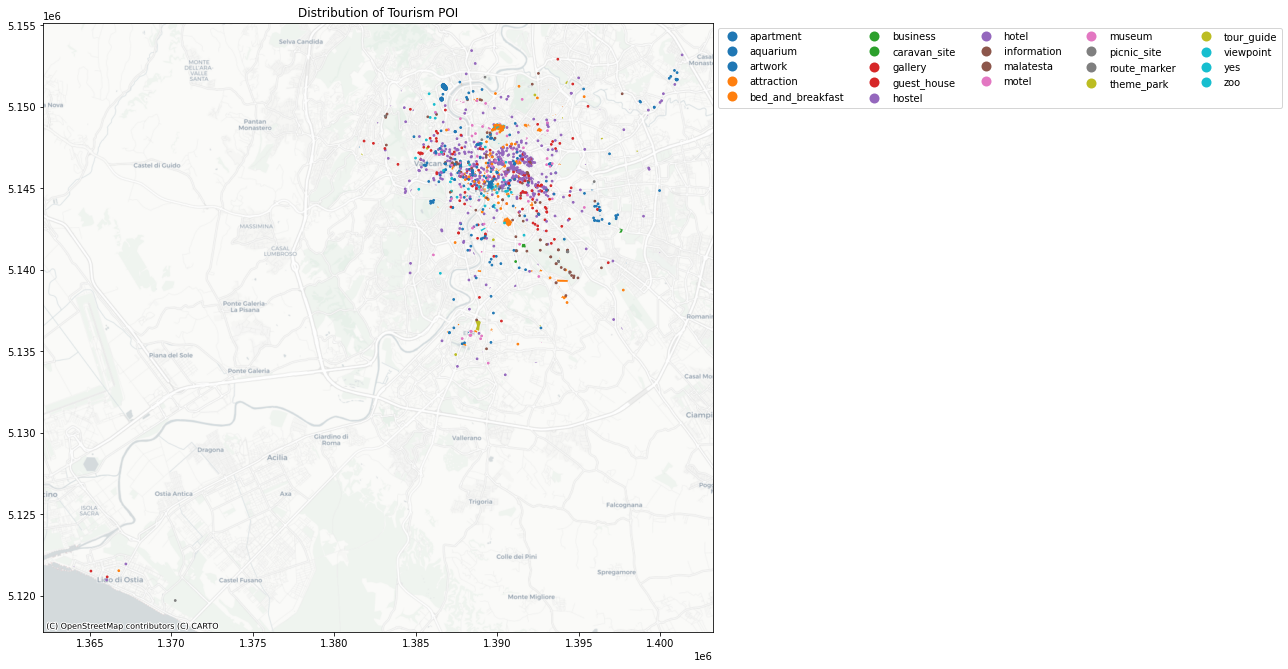

In [155]:
#visualize points of interest in a map
ax4 = pois_rome_tourism.to_crs(3857).plot(column='poi_type', markersize=3, figsize=(12,12), 
                             legend=True, legend_kwds = dict(loc='upper left',
                                                             ncol=5, bbox_to_anchor=(1,1)))
ctx.add_basemap(ax4,
                crs = pois_tourism.to_crs(epsg = 3857).crs.to_string(), 
                source=ctx.providers.CartoDB.Positron)
ax4.set_title('Distribution of Tourism POI')

With the spatial join between point of interest (pois_rome_tourism) and neighborhoods (merging_new) I get the number of tourist activites in each neighbor even though points on the bounds are lost.



In [156]:
print(" ",merging_neigh.crs, "\n ", pois_rome_tourism.crs)

  epsg:4265 
  epsg:4265


In [157]:
#spatial join
turism_point = gpd.sjoin(merging_neigh, 
                        pois_rome_tourism, how='inner', op='contains').reset_index()

turism_point = turism_point.drop(columns = 'index')
print(turism_point.shape)
turism_point.head(10)

(1584, 41)


neighbourhood  tot_schools  median_price  ...  artwork   zoo  poi_type
0  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
1  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
2  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
3  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
4  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
5  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN     hotel
6  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN    museum
7  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork
8  PRENESTINO LABICANO          154          44.0  ...     None  None   artwork
9  PRENESTINO LABICANO          154          44.0  ...      NaN   NaN   artwork

[10 rows x 41 columns]

There are some missing values in lat/lon columns that are replaced with the centroid of the polygon

In [158]:
turism_point.lat.fillna(value=turism_point.to_crs(epsg=4265).geometry.centroid.y, inplace=True)
turism_point.lon.fillna(value=turism_point.to_crs(epsg=4265).geometry.centroid.x, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [159]:
cols = ['neighbourhood', 
       'geometry', 
       'id', 'lat','lon', 'name',
       'tourism', 'osm_type']
turism_point = turism_point[cols]
turism_point.head()

neighbourhood  ... osm_type
0  PRENESTINO LABICANO  ...     node
1  PRENESTINO LABICANO  ...     node
2  PRENESTINO LABICANO  ...     node
3  PRENESTINO LABICANO  ...     node
4  PRENESTINO LABICANO  ...     node

[5 rows x 8 columns]

In [160]:
turism_point.crs # ok

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Change the geometry columns --> use points for the grouping and for the map

In [161]:
turism_point.drop(columns=["geometry"])
turism_point = gpd.GeoDataFrame(turism_point, crs='EPSG:4265',geometry=gpd.points_from_xy(turism_point.lon, turism_point.lat))
turism_point.head() 

neighbourhood                   geometry  ...  tourism  osm_type
0  PRENESTINO LABICANO  POINT (12.54842 41.87816)  ...  artwork      node
1  PRENESTINO LABICANO  POINT (12.54442 41.87989)  ...  artwork      node
2  PRENESTINO LABICANO  POINT (12.55214 41.88016)  ...  artwork      node
3  PRENESTINO LABICANO  POINT (12.53975 41.88051)  ...  artwork      node
4  PRENESTINO LABICANO  POINT (12.55227 41.88081)  ...  artwork      node

[5 rows x 8 columns]

In [162]:
total_tourism_and_neigh = turism_point.groupby('neighbourhood').size().to_frame('number_activities').sort_values(['number_activities', 'neighbourhood'], ascending=False).reset_index()
print("10 neighborhoods with highest number of tourist activities")
total_tourism_and_neigh.head(10)

10 neighborhoods with highest number of tourist activities


neighbourhood  number_activities
0  CASTRO PRETORIO                156
1   DELLA VITTORIA                110
2        PIANCIANO                105
3            MONTI                104
4        ESQUILINO                 96
5     CAMPO MARZIO                 61
6     APPIO LATINO                 58
7            BORGO                 55
8            TREVI                 53
9        TRIONFALE                 51

In [163]:
from folium.plugins import MarkerCluster

In [164]:
#function to get the markers for the map 
def getMarker(lat, lon, message, tip, inconstyle):
    marker = folium.Marker(location=[lat,lon],
                         popup=message,
                         tooltip=tip,
                         icon=inconstyle)
    return marker

#create folium map
fig5 = Figure(width=550,height=350)
m5 = folium.Map(location=[41.8919300,12.5113300], zoom_start=11)

#create cluster for the markers
marker_cluster = MarkerCluster().add_to(m5)

#loop to create the markers for each AirBnb
for index, row in turism_point.iterrows():
    icon=folium.Icon(color='purple',prefix='fa',icon='arrow-circle-down')
    message = '<strong>'+ str(row['name']) + "</strong><br/>" + row['neighbourhood']      
    tip = message + '<br/>' + row['tourism']
    marker = getMarker(row['lat'],row['lon'],message, tip, icon)
    
    #add to marker cluster 
    marker.add_to(marker_cluster)
    
fig5.add_child(m5)
m5

### SUMMARIZING RESULTS
The neighbors with highest number of tourst activites is CASTRO PRETORIO accounting for 156 activites. CASTRO PRETORIO is the RIONE XVIII in the centre of Rome (where we said most expensive rooms are available).

# **4. Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance) (city data portal and/oropenstreetmap)**



*   Filter activities for only "museums"
*   Choose a museo and filter the listings only for those in the same neighbor
* Perform Street Network Analysis



First I choose one of the museum in Rome, then to reduce computational time I filter the listing_join only for structures in the same neighbor of the museum

In [165]:
#create a subset that contains only museums
museums = turism_point[(turism_point['tourism'] == 'museum') ]
museums

neighbourhood                   geometry  ...  tourism  osm_type
6     PRENESTINO LABICANO  POINT (12.53463 41.88479)  ...   museum      node
49              ARDEATINO  POINT (12.50953 41.85646)  ...   museum      node
52              ARDEATINO  POINT (12.50630 41.84178)  ...   museum       way
59              ARDEATINO  POINT (12.49897 41.86970)  ...   museum      node
65              ARDEATINO  POINT (12.50630 41.84178)  ...   museum  relation
...                   ...                        ...  ...      ...       ...
1557                PIGNA  POINT (12.47943 41.89633)  ...   museum       way
1558                PIGNA  POINT (12.47670 41.89480)  ...   museum      node
1572                PIGNA  POINT (12.47873 41.89606)  ...   museum      node
1576                PIGNA  POINT (12.48153 41.89637)  ...   museum      node
1583                PIGNA  POINT (12.48156 41.89782)  ...   museum      node

[115 rows x 8 columns]

In [166]:
list(museums.name)

['Museo de la Memoria Gioccosa',
 '',
 'Museo delle Macchine Agricole',
 'Gruppo Storico Romano',
 'Ex Cartiera Latina',
 'Museo Anatomico "E. Morelli"',
 'Villa Leopardi',
 'Mueso delle Forze Alleate Roma',
 'Centrale Montemartini',
 'Museo di Storia della Medicina',
 'Technotown',
 'La Casina delle Civette',
 'Casino Nobile',
 'Casa Museo di Luigi Pirandello, archivio e biblioteca',
 'Musei Vaticani',
 'Museo Pio Clementino',
 'Museo Gregoriano Etrusco',
 'Mausoleo di Romolo',
 'Vigamus - Museo del Videogioco',
 'Museo astronomico e copernicano',
 'Casa Museo Alberto Moravia',
 "Museo dell'Astronomia e Planetario",
 'Museo della Civiltà Romana',
 'Museo delle poste e telecomunicazioni',
 'Museo Nazionale d\'Arte Orientale "G. Tucci"',
 'Museo Preistorico Etnografico "L. Pigorini"',
 'Museo di Geopaleontologia italiana Quintino Sella',
 'Museo Alto Medioevo "A. Vaccaro"',
 'Museo arti e tradizioni popolari "L. Loria"',
 'Archivio museo storico di Fiume',
 '',
 'Museo Internazionale de

In [167]:
import folium 
from branca.element import Figure

In [168]:
import osmnx as ox


In [169]:
# choose Musei Vaticani
musei_vaticani = museums[museums.name == "Musei Vaticani"]
musei_vaticani

neighbourhood                   geometry  ...  tourism  osm_type
211     TRIONFALE  POINT (12.43816 41.91834)  ...   museum       way

[1 rows x 8 columns]

By osmnx we can use the string of the city of interest and create a Rome graph with nodes and edges.

In [170]:
name_place = 'Rome, Italy'

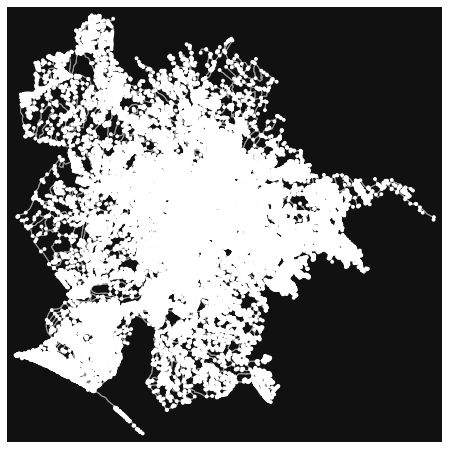

In [171]:
#create the walking route map in Rome
G = ox.graph_from_place(name_place, network_type='walk')
fig, ax = ox.plot_graph(G)

In [172]:
#add speed and travel 
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [173]:
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)

In [174]:
#now we can calculate the time needed to go from a place to another by walk
edges[edges.highway == 'footway'].head()

osmid  oneway lanes  ref  ... area         u           v  key
13                231621054   False   NaN  NaN  ...  NaN  21638013  2399668180    0
219               210676305   False   NaN  NaN  ...  NaN  25388392  2325425539    0
222               210676305   False   NaN  NaN  ...  NaN  25388392  1392753569    0
310               493764105   False   NaN  NaN  ...  NaN  25418925  4856394578    0
312  [493764105, 140757470]   False   NaN  NaN  ...  NaN  25418925  4856394573    0

[5 rows x 21 columns]

I need to find a nearest node of the chosen museum and again I can obtain it thanks to osmnx functions

In [175]:
point_museum = (musei_vaticani.lat.iloc[0], musei_vaticani.lon.iloc[0])
nearest_point_museo = ox.get_nearest_node(G,point_museum)
nearest_point_museo

299846834

**Filter listing_join for CAMPITELLI** for  computational reasons


In [176]:
trionfale_listing = listing_join[listing_join['neighbourhood'] == 'TRIONFALE']
print(trionfale_listing.shape)
trionfale_listing.head()

(1302, 7)


neighbourhood  ...                   geometry
8847     TRIONFALE  ...  POINT (12.45557 41.90740)
8848     TRIONFALE  ...  POINT (12.45505 41.90794)
8849     TRIONFALE  ...  POINT (12.45494 41.90798)
8850     TRIONFALE  ...  POINT (12.45508 41.90799)
8851     TRIONFALE  ...  POINT (12.45511 41.90810)

[5 rows x 7 columns]

In [177]:
trionfale_listing.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Add a column with the nearest node of each Airbnb structure in TRIONFALE.

In [178]:
trionfale_listing['nearest_node'] = trionfale_listing.geometry.apply(lambda point: ox.get_nearest_node(G, (point.y,point.x)))
trionfale_listing.head() #  take a while to run 

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


neighbourhood  ... nearest_node
8847     TRIONFALE  ...    153473920
8848     TRIONFALE  ...    130635160
8849     TRIONFALE  ...    130635160
8850     TRIONFALE  ...    130635160
8851     TRIONFALE  ...    130635160

[5 rows x 8 columns]

In [179]:
#dictionary of speed in each kind of highway/street
hwy_walking_speeds = {
    'motorway ': 0.5,
    'trunk': 0.5,
    'primary': 0.5,
    'secondary': 0.5,
    'tertiary': 0.5,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}
G = ox.add_edge_speeds(G,hwy_speeds=hwy_walking_speeds)
G = ox.add_edge_travel_times(G)

And add the route computed by walking distance --> there is no difference between the street from museum to each airbnb and to airbnb and the museum. 

In [180]:
trionfale_listing['route_from_museum'] = trionfale_listing.nearest_node.apply(lambda to_point: ox.shortest_path(G, nearest_point_museo, to_point))
trionfale_listing.head() #  take a while to run 

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


neighbourhood  ...                                  route_from_museum
8847     TRIONFALE  ...  [299846834, 299846960, 299849337, 299841237, 2...
8848     TRIONFALE  ...  [299846834, 299846960, 299849337, 299841237, 2...
8849     TRIONFALE  ...  [299846834, 299846960, 299849337, 299841237, 2...
8850     TRIONFALE  ...  [299846834, 299846960, 299849337, 299841237, 2...
8851     TRIONFALE  ...  [299846834, 299846960, 299849337, 299841237, 2...

[5 rows x 9 columns]

**Compute travel time** as walking distance

In [181]:
def travel_time_museum(inG, route):
    edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
    return (sum(edge_times))

trionfale_listing['travel_time'] = trionfale_listing.route_from_museum.apply(lambda route: travel_time_museum(G,route))

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [182]:
trionfale_listing.nearest_node.unique()

array([ 153473920,  130635160,  153403829,  130695995, 1841270524,
       1841270529,  307880156, 1990230754, 1299536921, 3508154493,
        307882211,  307880186, 2367380457,  224898178,  153474145,
       2159800862,  307880538,  307880289,  153474028, 2175080451,
        307880231, 1990230773,  307881723,   32642814, 1086092705,
       1389012558, 1389012560, 1055607714,  262023655, 2175080453,
        307880290, 1398913823,  294024481, 1286797429, 1198599871,
        748881182,  797701324, 1398913847,  797701331, 1398913858,
        797701322,  294024254,  797701323, 7138764264,  294027112,
        294027178, 2445853306, 2126730019, 1398913892,  797701325,
       2445853301, 1343116310, 1252279793, 1252279795,  294023574,
       1286797436,  377136465,  377136499,  377066790,  377066810,
       2126730027,  294027176,  294024144, 3136924421,  262020765,
       5686821151, 5614760855, 8356037991, 2400059448,  308101570,
       2126730029,  797701329,  377136454,   32642810, 2445853

Now sort airbnb for their closeness to the museum in terms of travel time. 

In [183]:
top_travel_time = trionfale_listing.sort_values(['travel_time'], ascending=True).reset_index().drop(columns='index')
top_travel_time[['name', 'host_name', 'travel_time', 'geometry','nearest_node']].head(10)

name  ... nearest_node
0                   Meraviglioso Mose' alla Balduina  ...    299846707
1                               Balduina Family Home  ...    299846774
2            Cozy apartment few minutes from Vatican  ...   1503397087
3                      Stanza in appartamento a Roma  ...   1503397087
4         Rome Sweet Rome Apt. Close to Vatican City  ...   2068512592
5                        Casa di Maffy alla Balduina  ...    760611775
6                                   Casa Pereira 205  ...    299846712
7    Chip & chic a few minutes away from the Vatican  ...    299846712
8                  Charming studio near Vatican City  ...    299847528
9  Roma Suite Balduina - Attico con favolosa terr...  ...    299845449

[10 rows x 5 columns]

### SUMMARIZING RESULTS
First closest hosts are:


1.   Meraviglioso Mose' alla Balduina --> 1 available room
2.   Balduina Family Home --> 1 available room
3.   Cozy apartment few minutes from Vatican --> 1 available room
4.   Stanza in appartamento a Roma 	--> 1 available room

Riccardo is the closest host.\
Hosts 3 and 4 have the same neareast node so the same travel time





Now retrieve the route from San Teodoro al Palatino Rooms & Loft Minerva to  Musei Capitolini 

In [184]:
#retrieve the route
route = top_travel_time.route_from_museum.iloc[0]
route

[299846834, 299846707]

In [185]:
#plot it
ox.plot_route_folium(G, route, tiles='OpenStreetMap')


I'm going to consider fisrt three closest hosts:

 

In [186]:
list(top_travel_time[0:4].nearest_node.unique())


[299846707, 299846774, 1503397087]

In [187]:
closest_hosts = top_travel_time[0:4]
closest_hosts

neighbourhood  ... travel_time
0     TRIONFALE  ...         6.8
1     TRIONFALE  ...         7.2
2     TRIONFALE  ...        11.9
3     TRIONFALE  ...        11.9

[4 rows x 10 columns]

In [188]:
hosts_np= list(closest_hosts.nearest_node.unique())

In [189]:
hosts_np

[299846707, 299846774, 1503397087]

In [190]:
hosts_np[1] # nearest node

299846774

In [191]:
maps= []
for i in range(len(hosts_np)):
  first_airbnb_route = ox.shortest_path(G,nearest_point_museo,hosts_np[i],weight='travel_time')
  graph_folium_map = ox.plot_route_folium(G,first_airbnb_route, tiles = 'openstreetmap')

  for index, row in closest_hosts.iterrows():
    icon=folium.features.CustomIcon('https://www.shareicon.net/data/512x512/2016/07/10/119904_airbnb_512x512.png',
                                    icon_size=(30,30))
    marker = getMarker(row.geometry.y,row.geometry.x,
                       row['host_name'],
                       row['name'],
                       icon)
    marker.add_to(graph_folium_map)
    #marker = getMarker(row['lat'],row['lon'],message, tip, icon)

  for index, row in musei_vaticani.iterrows():
    icon=folium.features.CustomIcon('https://tse4.mm.bing.net/th?id=OIP.EgeNmVWdKhqZ8mkWEmVLfgHaHa&pid=Api',
                                    icon_size=(30,30))
    marker = getMarker(row['lat'], row['lon'],
                       row['neighbourhood'],
                       row['name'],
                       icon)
    marker.add_to(graph_folium_map)

  maps.append(graph_folium_map)

In [192]:
maps[0]

For the export file I need to add to merging_new information about tourist activities (number_activities)

In [193]:
for_export = pd.merge(merging_neigh, total_tourism_and_neigh, on = 'neighbourhood')
print(for_export.shape)
for_export.head()

(53, 8)


neighbourhood  ...  number_activities
0  PRENESTINO LABICANO  ...                 27
1            TUSCOLANO  ...                 20
2            ARDEATINO  ...                 29
3         GIANICOLENSE  ...                 29
4              TRIESTE  ...                 19

[5 rows x 8 columns]

# **5. Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m (city data portal and/or openstreetmap- analyze and test spatial autocorrelation of price- represent these analyses on maps (web and not)**



*   Customize filter for services of interest and visualize services (pois) on a map
*   create the geodataframe with closest hosts
*   convert all the points in utm32n



In [194]:
#custom filter with the things i need
custom_filter = {'shop':['supermarket'],'amenity':['pharmacy','restaurant']}
pois = osm.get_pois(custom_filter = custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])
pois.head()


timestamp  version        lon  ...  building:levels wikipedia    poi_type
0  1596631751        3  12.535002  ...              NaN       NaN    pharmacy
1  1614137574       11  12.473790  ...              NaN       NaN  restaurant
2  1540294350        9  12.499475  ...              NaN       NaN  restaurant
3  1273587122        3  12.485462  ...              NaN       NaN    pharmacy
4  1301065366        4  12.502097  ...              NaN       NaN    pharmacy

[5 rows x 41 columns]

Text(0.5, 1.0, 'Distribution of Supermarkets, Pharmacies and Restaurants')

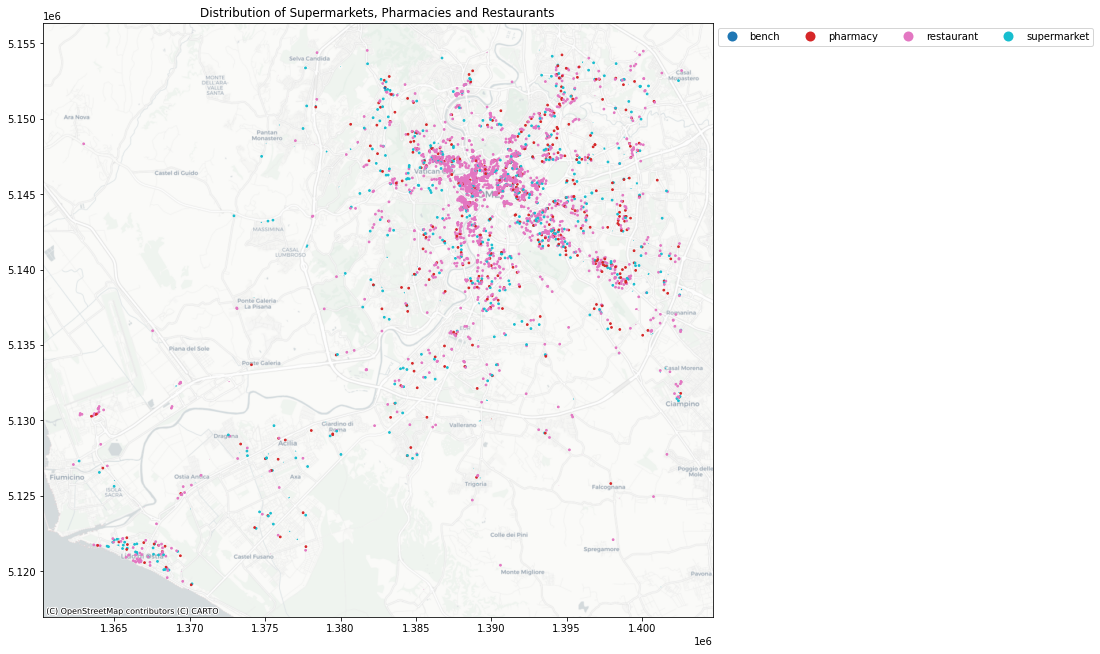

In [195]:
# Plot
ax6 = pois.to_crs(3857).plot(column='poi_type', markersize=3,
               figsize=(12,12), legend=True, 
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1))
               )
ctx.add_basemap(ax6,
                crs = pois.to_crs(epsg = 3857).crs.to_string(),
                source=ctx.providers.CartoDB.Positron)
ax6.set_title('Distribution of Supermarkets, Pharmacies and Restaurants')

In [196]:
pois.columns

Index(['timestamp', 'version', 'lon', 'id', 'tags', 'lat', 'changeset',
       'addr:city', 'addr:country', 'addr:housenumber', 'addr:housename',
       'addr:postcode', 'addr:place', 'addr:street', 'email', 'name',
       'opening_hours', 'operator', 'phone', 'ref', 'url', 'website',
       'ice_cream', 'mobile_phone', 'music', 'organic', 'outdoor', 'shop',
       'supermarket', 'amenity', 'bar', 'internet_access', 'restaurant',
       'source', 'start_date', 'geometry', 'osm_type', 'building',
       'building:levels', 'wikipedia', 'poi_type'],
      dtype='object')

In [197]:
pois = pois[['name','tags','lat','lon','osm_type','amenity','geometry']]
pois.head()

name  ...                   geometry
0                      None  ...  POINT (12.53500 41.88681)
1         Pizzeria ai Marmi  ...  POINT (12.47379 41.88826)
2  Ristorante Old Hang Zhou  ...  POINT (12.49948 41.89580)
3                      None  ...  POINT (12.48546 41.85236)
4            Farmacia Ricci  ...  POINT (12.50210 41.89763)

[5 rows x 7 columns]

In [198]:
closest_hosts = gpd.GeoDataFrame(closest_hosts, crs="epsg:4265")#,geometry=gpd.points_from_xy(closest_hosts.geometry.y, closest_hosts.geometry.x))
closest_hosts

neighbourhood  ... travel_time
0     TRIONFALE  ...         6.8
1     TRIONFALE  ...         7.2
2     TRIONFALE  ...        11.9
3     TRIONFALE  ...        11.9

[4 rows x 10 columns]

In [217]:
#It is necessary to convert all the points in utm32n, to compute the distances in meters (for the buffer)
import pyproj
from shapely.ops import transform    
pois = pois.to_crs(epsg = 32632)

#step to permit the conversion
wgs84 = pyproj.CRS('EPSG:4265')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

#create variables for the three hosts
host1 = closest_hosts.iloc[0]
host2 = closest_hosts.iloc[1]
host3 = closest_hosts.iloc[2]

#convert to utm32n
host1 = transform(projection_transform, Point(host1.geometry.y, host1.geometry.x))
host2 = transform(projection_transform, Point(host2.geometry.y, host2.geometry.x))
host3 = transform(projection_transform, Point(host3.geometry.y, host3.geometry.x))

In [221]:
#for host1 - Riccardo
host_1 = pois[pois.geometry.within(host1.buffer(300))]
host_1['host_name'] = closest_hosts.host_name[0]
host_1['room_type'] = closest_hosts.room_type[0]
print(len(host_1))
host_1

6


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


name  ...        room_type
17                                  None  ...  Entire home/apt
213                      Il Chiodo Fisso  ...  Entire home/apt
364                                  PAM  ...  Entire home/apt
542                              Capperi  ...  Entire home/apt
1262  Farmacia dott.ssa Renata Gerardini  ...  Entire home/apt
2105                           Altrogiro  ...  Entire home/apt

[6 rows x 9 columns]

In [223]:
#for host2 - Maurizio
host_2 = pois[pois.geometry.within(host2.buffer(300))]
host_2['host_name'] = closest_hosts.host_name[1]
host_2['room_type'] = closest_hosts.room_type[1]
print(len(host_2))
host_2

9


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


name  ...        room_type
17                                  None  ...  Entire home/apt
213                      Il Chiodo Fisso  ...  Entire home/apt
341                    Farmacia Balduina  ...  Entire home/apt
342                     Carrefour Market  ...  Entire home/apt
349                        Simply Market  ...  Entire home/apt
364                                  PAM  ...  Entire home/apt
540                       Farmacia Rallo  ...  Entire home/apt
1262  Farmacia dott.ssa Renata Gerardini  ...  Entire home/apt
2105                           Altrogiro  ...  Entire home/apt

[9 rows x 9 columns]

In [225]:
#for host3 - Dina or MariaLuisa  (same nearest node)
host_3 = pois[pois.geometry.within(host3.buffer(300))]
host_3['host_name'] = closest_hosts.host_name[3]
host_3['room_type'] = closest_hosts.room_type[3]


print(len(host_3))
host_3

6


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


name  ...     room_type
315                   Farmacia Pollicina  ...  Private room
341                    Farmacia Balduina  ...  Private room
364                                  PAM  ...  Private room
542                              Capperi  ...  Private room
1262  Farmacia dott.ssa Renata Gerardini  ...  Private room
2105                           Altrogiro  ...  Private room

[6 rows x 9 columns]

In [226]:
pd1 = host_1.append([host_2,host_3])
pd1

name  ...        room_type
17                                  None  ...  Entire home/apt
213                      Il Chiodo Fisso  ...  Entire home/apt
364                                  PAM  ...  Entire home/apt
542                              Capperi  ...  Entire home/apt
1262  Farmacia dott.ssa Renata Gerardini  ...  Entire home/apt
2105                           Altrogiro  ...  Entire home/apt
17                                  None  ...  Entire home/apt
213                      Il Chiodo Fisso  ...  Entire home/apt
341                    Farmacia Balduina  ...  Entire home/apt
342                     Carrefour Market  ...  Entire home/apt
349                        Simply Market  ...  Entire home/apt
364                                  PAM  ...  Entire home/apt
540                       Farmacia Rallo  ...  Entire home/apt
1262  Farmacia dott.ssa Renata Gerardini  ...  Entire home/apt
2105                           Altrogiro  ...  Entire home/apt
315                   Farmacia Pollicina  ...     Private room
341                    Farmacia Balduina  ...     Private room
364                                  PAM  ...     Private room
542                              Capperi  ...     Private room
1262  Farmacia dott.ssa Renata Gerardini  ...     Private room
2105                           Altrogiro  ...     Private room

[21 rows x 9 columns]

In [227]:
pd1.groupby(["host_name"]).size().to_frame("N. of services").sort_values(by=["N. of services"],ascending=False).reset_index()

host_name  N. of services
0     Maurizio               9
1  Maria Luisa               6
2     Riccardo               6

In [228]:
pd1.groupby(["host_name",'amenity','room_type']).size().to_frame("amount")

amount
host_name   amenity    room_type              
Maria Luisa pharmacy   Private room          3
            restaurant Private room          2
Maurizio    pharmacy   Entire home/apt       4
            restaurant Entire home/apt       2
Riccardo    pharmacy   Entire home/apt       2
            restaurant Entire home/apt       3

### SUMMARIZING RESULTS
Maurizio is the one with highest numbers of activities nearby (2 restaurants and 4 pharmacies), while


In [206]:
#sch_tot.head()

In [207]:
#for_export.head()

#Export

In [208]:
rome_export = pd.merge(for_export, sch_tot)
rome_export = rome_export.rename(columns = {'number_activities':'tourist_activites', 'total':'schools'})
print(rome_export.shape)
#rome_export

(53, 8)


In [209]:
rome_export = gpd.GeoDataFrame(
    rome_export,
    crs = 'EPSG:4265')#, #specify the system of coordinates 
    #geometry=gpd.points_from_xy(rome.longitude,rome.latitude))   #and instruct geopandas regarding in which columns it can find the spatial coordinates of the units

rome_export.head()

neighbourhood  ...  tourist_activites
0  PRENESTINO LABICANO  ...                 27
1            TUSCOLANO  ...                 20
2            ARDEATINO  ...                 29
3         GIANICOLENSE  ...                 29
4              TRIESTE  ...                 19

[5 rows x 8 columns]

In [210]:
rome_export.shape

(53, 8)

In [211]:
rome_export.crs

<Geographic 2D CRS: EPSG:4265>
Name: Monte Mario
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Italy - onshore and offshore; San Marino, Vatican City State.
- bounds: (5.93, 34.76, 18.99, 47.1)
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [212]:
rome_export.isnull().sum().to_frame()


0
neighbourhood      0
tot_schools        0
median_price       0
population         0
area               0
pop_density        0
geometry           0
tourist_activites  0

In [213]:
rome_export.to_file("rome_analysis.gpkg", layer='neighbourhood', driver="GPKG")

In [214]:
from google.colab import files

In [215]:
#!ls

In [216]:
files.download('/content/rome_analysis.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>